### 所用的算法未采用联合损失函数等手段，训练次数多了仍然会梯度爆炸，但当前主要研究动作约束对训练的影响，暂且忽略前者问题

#### 无栏杆，正常训练，但是“不安全”

Iteration: 100%|██████████| 200/200 [00:07<00:00, 26.77it/s, episode=200, return=17.212]


出界次数： 4


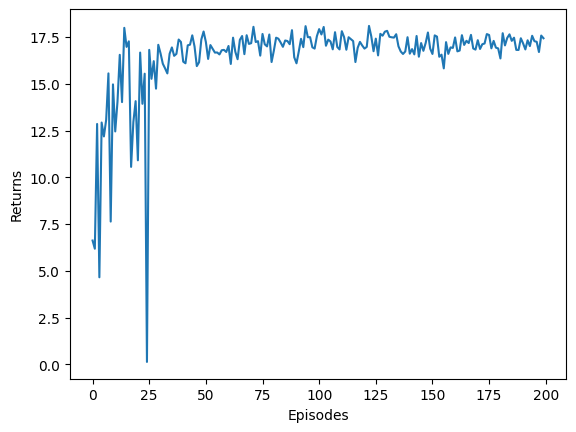

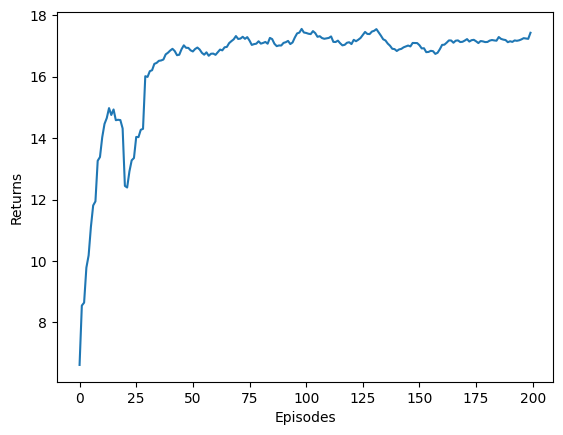

In [3]:
# 游标训练环境
import random
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None
        self.out_range = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        self.out_range = 0
        return self.get_obs()
        
    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move # + np.random.normal()
        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
            self.out_range = 1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            return 1-np.linalg.norm(self.position-(self.max_pos+self.min_pos)/2)/10
        else:
            return 0 # -3

import sys
import os
sys.path.append(os.path.abspath(".."))

from Algorithms.PPOcontinues import *

# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200 # fixme 如果不限制最小方差，500 的时候会梯度爆炸, 限制后1000 也会爆炸
hidden_dims = [128]  # 128 fixme 层数大时actor梯度也会爆炸
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)
out_range_count = 0
return_list = []
clear_batch_flag=1
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        if clear_batch_flag:
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            clear_batch_flag=0
        state = env.reset()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action = agent.take_action(state, action_bound=action_bound, explore=True)
            next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward

        if env.out_range==1:
            out_range_count+=1
            
        return_list.append(episode_return)
        if 1: # len(transition_dict['dones'])>20: # 逐batch更新
            agent.update(transition_dict, action_bound)
            clear_batch_flag=1
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

%matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))

print("出界次数：", out_range_count)

#### 在env加栏杆，如果不限制最小方差会梯度爆炸，限制了也有概率爆炸

Iteration:  47%|████▋     | 235/500 [00:08<00:09, 26.92it/s, episode=235, return=9.997] 


ValueError encountered: NaN in Actor outputs in loop. Exiting the loop.
出界次数： 0


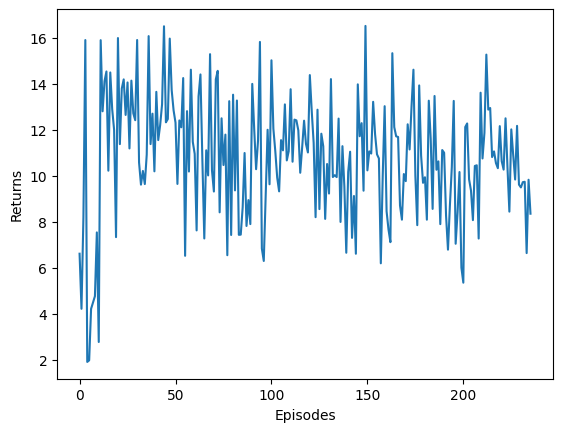

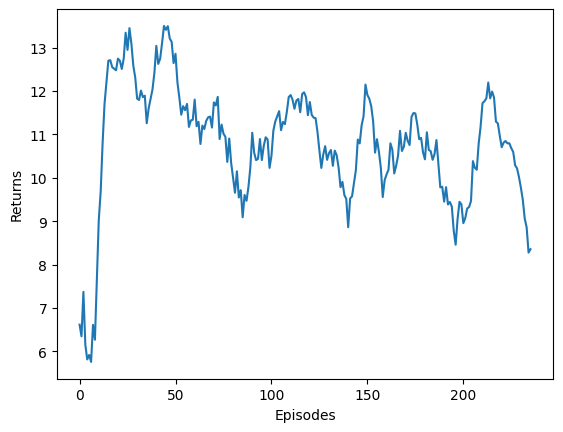

In [ ]:
# 游标训练环境
import random
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None
        self.out_range = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        self.out_range = 0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move # + np.random.normal()
        self.position = np.clip(self.position, self.min_pos, self.max_pos) # 栏杆
        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
            self.out_range = 1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            return 1-np.linalg.norm(self.position-(self.max_pos+self.min_pos)/2)/10
        else:
            return 0 # -3

import sys
import os
sys.path.append(os.path.abspath(".."))

from Algorithms.PPOcontinues import *

# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 500 # fixme 500 的时候会梯度爆炸
hidden_dims = [128]  # 128
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr, lmbda, epochs, eps, gamma, device)
out_range_count = 0
return_list = []
clear_batch_flag=1
try:
    with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
        for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
            episode_return = 0
            if clear_batch_flag:
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': [], 'action_bounds':[]}
                clear_batch_flag=0
            state = env.reset()
            done = False
            while not done:  # 每个训练回合
                # state_check=state
                # 1.执行动作得到环境反馈
                action = agent.take_action(state, action_bound=action_bound, explore=True)
                next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
                # print(reward)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                'action_bounds'

                state = next_state
                episode_return += reward

            if env.out_range==1:
                out_range_count+=1
                
            return_list.append(episode_return)
            if 1: # len(transition_dict['dones'])>20: # 逐batch更新
                agent.update(transition_dict, action_bound)
                clear_batch_flag=1
            if (i_episode + 1) >= 10:
                pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                                  'return': '%.3f' % np.mean(return_list[-10:])})
            pbar.update(1)

except ValueError as e:
    print(f"ValueError encountered: {e}. Exiting the loop.")

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)
finally:
    # 无论是否发生异常，这部分代码都会被执行
    

    episodes_list = list(range(len(return_list)))
    plt.figure()
    plt.plot(episodes_list, return_list)
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    # plt.title('PPO on {}'.format(env_name))


    mv_return = moving_average(return_list, 9)
    plt.figure()
    plt.plot(episodes_list, mv_return)
    plt.xlabel('Episodes')
    plt.ylabel('Returns')
    # plt.title('PPO on {}'.format(env_name))

    print("出界次数：", out_range_count)


#### PPO with Squashed Gaussian 未加栏杆

Iteration: 100%|██████████| 200/200 [00:07<00:00, 27.70it/s, episode=200, return=17.067]


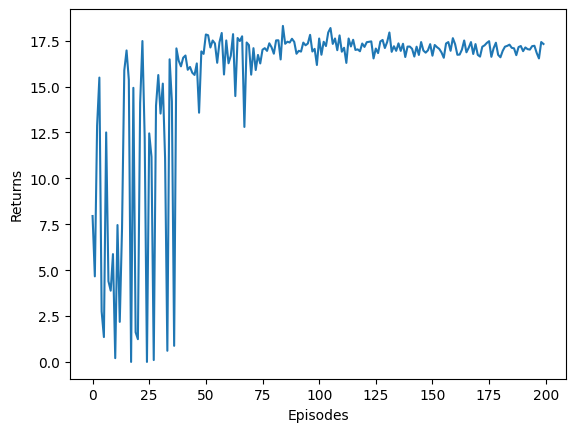

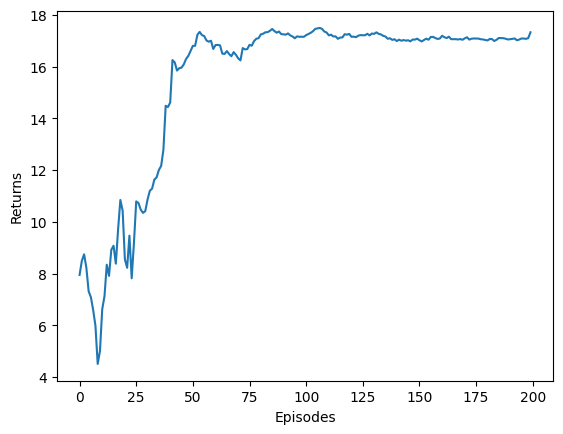

出界次数： 18


In [7]:
# 游标训练环境
import random
import matplotlib
import matplotlib.pyplot as plt
import gym
from gym import spaces
from numpy.linalg import norm
from torch.distributions import Normal
import random
import numpy as np
from tqdm import tqdm
import collections
import torch
from torch import nn
import torch.nn.functional as F

# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None
        self.out_range = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        self.out_range = 0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move # + np.random.normal()
        # self.position = np.clip(self.position, self.min_pos, self.max_pos) # 栏杆

        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
            self.out_range = 1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            reward1 = 1 - np.linalg.norm(self.position - (self.max_pos + self.min_pos) / 2) / 10
        else:
            reward1 = 0 # -3
        return reward1

# 改进算法

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()

        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(torch.nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_out = torch.nn.Linear(prev_size, 1)

    def forward(self, x):
        y = self.net(x)
        return self.fc_out(y)


class SquashedNormal:
    """带 tanh 压缩的高斯分布。

    采样：u ~ N(mu, std)（使用 rsample 支持 reparam），a = tanh(u)
    log_prob：基于 u 的 normal.log_prob(u) 并加上 tanh 的 Jacobian 修正项：-sum log(1 - tanh(u)^2)
    注意：外部需要把动作缩放到环境动作空间（仿射变换）。
    """

    def __init__(self, mu, std, eps=1e-6):
        self.mu = mu
        self.std = std
        self.normal = Normal(mu, std)
        self.eps = eps

    def sample(self):
        # rsample 以支持 reparameterization 重参数化采样, 结果是可导的
        u = self.normal.rsample()
        a = torch.tanh(u)
        return a, u

    def log_prob(self, a, u):
        # a: tanh(u)
        # log_prob(u) - sum log(1 - tanh(u)^2)
        # normal.log_prob 返回每个维度的 log_prob，需要 sum
        # 为数值稳定性添加小量
        log_prob_u = self.normal.log_prob(u)
        # jacobian term
        jacobian = torch.log(1 - a.pow(2) + self.eps) # fixme 应该+还是-？
        # sum over action dim, keep dims consistent: return (N, 1)
        return (log_prob_u - jacobian).sum(-1, keepdim=True)

    def entropy(self):
        # 近似：使用 base normal 的熵之和（不考虑 tanh 的修正）
        # 这在实践中通常足够，若需精确熵可用采样估计
        ent = self.normal.entropy().sum(-1)
        return ent


class PolicyNetContinuous(torch.nn.Module):
    """输出未压缩（pre-squash）的 mu 和 std。

    网络输出的 mu 是未经过 tanh 的原始均值，std 用 softplus 保证正值。
    不在网络内部做 action scaling，统一在采样/执行阶段处理。
    """

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_mu = torch.nn.Linear(prev_size, action_dim)
        self.fc_std = torch.nn.Linear(prev_size, action_dim)

    def forward(self, x, min_std=1e-3):
        x = self.net(x)
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        std = torch.clamp(std, min=min_std)
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法，支持时变动作区间（每步 amin/amax 不同）。

    设计说明（必须注意）：
    - 如果环境的动作约束随状态变化（amin/amax 为时变），则经验回放需保存当时的
      amin/amax（请把它放到 transition_dict['action_bounds']，形状为 (N, 2) 或每步的 (amin, amax)）。
    - 如果 action_bounds 在训练时始终恒定（标量或单个区间），也可以直接把 action_bound
      作为常数传入 update()。
    - 在本实现中，策略内部输出的是标准化前的 mu 和 std（即对 u 的分布参数）。
      对应的执行动作为：a = tanh(u)  -> normalized in (-1,1)
      最后缩放到真实区间： a_exec = amin + (a+1)/2 * (amax-amin)
    - update() 中会把存储的 a_exec "反归一化" 回 normalized a（[-1,1]），以便计算 log_prob。
    '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def _scale_action_to_exec(self, a, action_bounds):
        """把 normalized action a (in [-1,1]) 缩放到环境区间。

        action_bounds 可以是：
        - 单个数值：action_bound，表示对称区间 [-action_bound, action_bound]
        - 长度为 2 的元组/列表 (amin, amax)
        - 每步的数组，形状 (N, 2)
        """
        if isinstance(action_bounds, (int, float)):
            # 对称区间
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a.dtype, device=a.device)
        amax = torch.as_tensor(amax, dtype=a.dtype, device=a.device)
        # a in (-1,1) -> scale to [amin, amax]
        return amin + (a + 1.0) * 0.5 * (amax - amin)

    def _unscale_exec_to_normalized(self, a_exec, action_bounds):
        """把执行动作 a_exec 反向归一化到 [-1,1]。

        如果 action_bounds 是标量，视作对称区间 [-b, b]。
        返回 normalized action (in (-1,1)).
        """
        if isinstance(action_bounds, (int, float)):
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a_exec.dtype, device=a_exec.device)
        amax = torch.as_tensor(amax, dtype=a_exec.dtype, device=a_exec.device)
        # 防止除以零
        span = (amax - amin)
        span = torch.where(span == 0, torch.tensor(1e-6, device=span.device, dtype=span.dtype), span)
        a = 2.0 * (a_exec - amin) / span - 1.0
        # numerical stability
        return a.clamp(-0.999999, 0.999999)

    def take_action(self, state, action_bounds=1.0, explore=True):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        dist = SquashedNormal(mu, std)
        if explore:
            a_norm, u = dist.sample()
        else:
            # use mean action: tanh(mu)
            u = mu
            a_norm = torch.tanh(u)

        # # scale to actual action bounds
        # if isinstance(action_bounds, (int, float)):
        #     amin = -float(action_bounds)
        #     amax = float(action_bounds)
        # else:
        #     amin, amax = action_bounds
        # amin = torch.as_tensor(amin, dtype=a_norm.dtype, device=a_norm.device)
        # a_exec = amin + (a_norm + 1.0) * 0.5 * (float(amax) - float(amin))
        # return a_exec[0].cpu().detach().numpy().flatten()
        # 调用 _scale_action_to_exec 进行动作缩放

        a_exec = self._scale_action_to_exec(a_norm, action_bounds)
        return a_exec[0].cpu().detach().numpy().flatten()
    


    def update(self, transition_dict, action_bounds=None):
        """更新函数兼容以下几种调用方式：
        - 如果 action_bounds 是 None：期望 transition_dict 中包含 'action_bounds'，其形状为 (N,2) 或每步 (amin,amax)
        - 如果 action_bounds 是标量/二元元组/数组：作为全局固定区间使用

        transition_dict 必须包含 keys: 'states','actions','rewards','next_states','dones'
        当动作区间随步变化时，必须包含 'action_bounds' 与之对应。
        存储的 'actions' 应当是环境执行动作 a_exec（未归一化）。
        """
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions_exec = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # # 获取每步的 action_bounds，如果外部传入了 action_bounds 参数则优先使用
        # if action_bounds is None:
        #     if 'action_bounds' not in transition_dict:
        #         action_bounds = 1.0
        #         # raise KeyError("action_bounds 未提供：当动作约束为时变时，transition_dict 必须包含 'action_bounds'")
        #     # action_bounds_arr = transition_dict['action_bounds']
        # else:
        #     # 将固定 action_bounds 扩展为每步相同的序列，方便后续计算
        #     action_bounds_arr = [action_bounds] * len(transition_dict['actions'])

        if action_bounds is None:
            if 'action_bounds' in transition_dict:
                action_bounds = transition_dict['action_bounds']
            else:
                action_bounds = 1.0  # 默认值

        # 将 action_bounds 处理为每步的数组
        if isinstance(action_bounds, (int, float)):
            # 对称区间，扩展为每步相同的区间
            # action_bounds_arr = [action_bounds] * len(transition_dict['actions'])
            amin_list = [-float(action_bounds)] * len(transition_dict['actions'])
            amax_list = [float(action_bounds)] * len(transition_dict['actions'])
        elif isinstance(action_bounds, (tuple, list, np.ndarray)) and len(action_bounds) == 2:
            # 二元元组或列表，扩展为每步相同的 min 和 max
            amin_list = [float(action_bounds[0])] * len(transition_dict['actions'])
            amax_list = [float(action_bounds[1])] * len(transition_dict['actions'])
        else:
            # 每步不同的区间，直接解包
            amin_list = [float(ab[0]) if isinstance(ab, (tuple, list, np.ndarray)) else -float(ab) for ab in action_bounds]
            amax_list = [float(ab[1]) if isinstance(ab, (tuple, list, np.ndarray)) else float(ab) for ab in action_bounds]

        # 转换为张量
        amin_tensor = torch.tensor(amin_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)
        amax_tensor = torch.tensor(amax_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)

        # # 将 action_bounds 处理为每步的数组
        # if isinstance(action_bounds, (int, float)):
        #     action_bounds_arr = [action_bounds] * len(transition_dict['actions'])
        # else:
        #     action_bounds_arr = action_bounds

        # 将 action_bounds_arr 变为 tensor，形状 (N, 2)
        # 支持传入每步为 (amin,amax) 或 标量
        # amin_list = []
        # amax_list = []
        # for ab in action_bounds_arr:
        #     if isinstance(ab, (int, float)):
        #         amin_list.append(-float(ab))
        #         amax_list.append(float(ab))
        #     else:
        #         amin_list.append(float(ab[0]))
        #         amax_list.append(float(ab[1]))
        # amin_tensor = torch.tensor(amin_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)
        # amax_tensor = torch.tensor(amax_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)

        # 计算 td_target, advantage
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # 策略输出（未压缩的 mu,std）
        mu, std = self.actor(states)
        # 构造 SquashedNormal 并计算 old_log_probs
        dist = SquashedNormal(mu.detach(), std.detach())

        # 将执行动作反向归一化到 [-1,1]，以便计算 log_prob
        # actions_normalized = 2.0 * (actions_exec - amin_tensor) / (amax_tensor - amin_tensor + 1e-8) - 1.0
        # actions_normalized = actions_normalized.clamp(-0.999999, 0.999999)
        actions_normalized = self._unscale_exec_to_normalized(actions_exec, (amin_tensor, amax_tensor))
        
        # 反算 u = atanh(a)
        u_old = torch.atanh(actions_normalized)
        old_log_probs = dist.log_prob(actions_normalized, u_old)

        if torch.isnan(old_log_probs).any():
            raise ValueError("old_log_probs 包含 NaN，检查 action_bounds 或 actions 的合法性")

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            if torch.isnan(mu).any() or torch.isnan(std).any():
                raise ValueError("NaN in Actor outputs in loop")
            critic_values = self.critic(states)
            if torch.isnan(critic_values).any():
                raise ValueError("NaN in Critic outputs in loop")

            dist = SquashedNormal(mu, std)
            # 计算当前策略对历史执行动作的 log_prob（使用同一个 u_old）
            log_probs = dist.log_prob(actions_normalized, u_old)

            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = -torch.min(surr1, surr2).mean() - 0.1 * dist.entropy().mean()

            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()

            # 梯度裁剪
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=2)
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=2)

            self.actor_optimizer.step()
            self.critic_optimizer.step()


# 注意：为了兼容原来的训练循环，请在构造 transition_dict 时保证：
# - 'actions' 存储的是环境实际执行的动作 a_exec（未归一化）
# - 如果动作区间随步变化，则 transition_dict['action_bounds'] 应为长度为步数的序列，
#   其中每个元素是 (amin, amax) 或 标量 b（表示对称区间 [-b,b]）。
# 示例：
# transition = {
#   'states': [...],
#   'actions': [...],  # 执行到环境的动作
#   'rewards': [...],
#   'next_states': [...],
#   'dones': [...],
#   'action_bounds': [(amin0,amax0), (amin1,amax1), ...]  # 可选
# }

# 以上实现把 action_bounds 纳入了 update 的计算链路，从而保证了 log_prob 的计算与当时执行动作的一致性，
# 避免了因动作裁剪/投影导致的策略-执行分布不匹配，从根本上缓解了你提到的 update 中梯度爆炸问题。


# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200 # fixme 如果不限制最小方差，500 的时候会梯度爆炸, 限制后1000 也会爆炸
hidden_dims = [128]  # 128 fixme 层数大时actor梯度也会爆炸
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1




action_bound = 3  # 动作最大值

agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)
out_range_count = 0
return_list = []
clear_batch_flag=1
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        if clear_batch_flag:
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            clear_batch_flag=0
        state = env.reset()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action = agent.take_action(state, action_bounds=action_bound, explore=True)
            next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward

        if env.out_range==1:
            out_range_count+=1

        return_list.append(episode_return)
        if 1: # len(transition_dict['dones'])>20: # 逐batch更新
            agent.update(transition_dict, action_bound)
            clear_batch_flag=1
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

# %matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))

plt.show()

print("出界次数：", out_range_count)

#### ☆ 在action中加栏杆 + Squashed PPO

Iteration: 100%|██████████| 200/200 [00:07<00:00, 27.17it/s, episode=200, return=17.042]


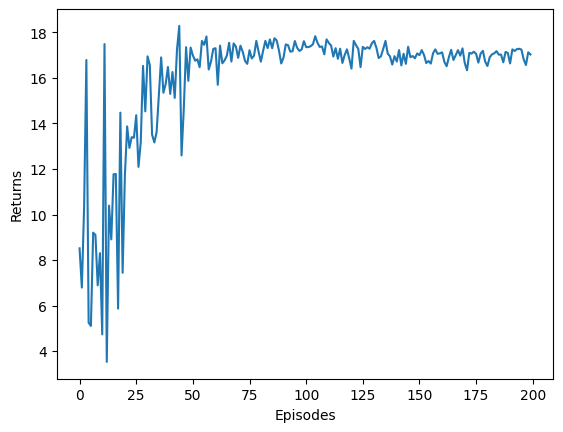

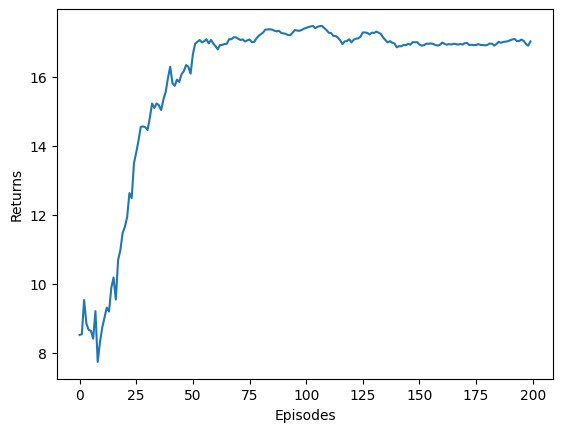

出界次数： 0


In [8]:
# 游标训练环境
import random
import matplotlib
import matplotlib.pyplot as plt
import gym
from gym import spaces
from numpy.linalg import norm
from torch.distributions import Normal
import random
import numpy as np
from tqdm import tqdm
import collections
import torch
from torch import nn
import torch.nn.functional as F

# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None
        self.out_range = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        self.out_range = 0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move # + np.random.normal()
        # self.position = np.clip(self.position, self.min_pos, self.max_pos) # 栏杆

        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
            self.out_range = 1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            reward1 = 1 - np.linalg.norm(self.position - (self.max_pos + self.min_pos) / 2) / 10
        else:
            reward1 = 0 # -3
        return reward1

# 改进算法

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()

        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(torch.nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_out = torch.nn.Linear(prev_size, 1)

    def forward(self, x):
        y = self.net(x)
        return self.fc_out(y)


class SquashedNormal:
    """带 tanh 压缩的高斯分布。

    采样：u ~ N(mu, std)（使用 rsample 支持 reparam），a = tanh(u)
    log_prob：基于 u 的 normal.log_prob(u) 并加上 tanh 的 Jacobian 修正项：-sum log(1 - tanh(u)^2)
    注意：外部需要把动作缩放到环境动作空间（仿射变换）。
    """

    def __init__(self, mu, std, eps=1e-6):
        self.mu = mu
        self.std = std
        self.normal = Normal(mu, std)
        self.eps = eps

    def sample(self):
        # rsample 以支持 reparameterization 重参数化采样, 结果是可导的
        u = self.normal.rsample()
        a = torch.tanh(u)
        return a, u

    def log_prob(self, a, u):
        # a: tanh(u)
        # log_prob(u) - sum log(1 - tanh(u)^2)
        # normal.log_prob 返回每个维度的 log_prob，需要 sum
        # 为数值稳定性添加小量
        log_prob_u = self.normal.log_prob(u)
        # jacobian term
        jacobian = torch.log(1 - a.pow(2) + self.eps) # fixme 应该+还是-？
        # sum over action dim, keep dims consistent: return (N, 1)
        return (log_prob_u - jacobian).sum(-1, keepdim=True)

    def entropy(self):
        # 近似：使用 base normal 的熵之和（不考虑 tanh 的修正）
        # 这在实践中通常足够，若需精确熵可用采样估计
        ent = self.normal.entropy().sum(-1)
        return ent


class PolicyNetContinuous(torch.nn.Module):
    """输出未压缩（pre-squash）的 mu 和 std。

    网络输出的 mu 是未经过 tanh 的原始均值，std 用 softplus 保证正值。
    不在网络内部做 action scaling，统一在采样/执行阶段处理。
    """

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_mu = torch.nn.Linear(prev_size, action_dim)
        self.fc_std = torch.nn.Linear(prev_size, action_dim)

    def forward(self, x, min_std=1e-3):
        x = self.net(x)
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        std = torch.clamp(std, min=min_std)
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法，支持时变动作区间（每步 amin/amax 不同）。

    设计说明（必须注意）：
    - 如果环境的动作约束随状态变化（amin/amax 为时变），则经验回放需保存当时的
      amin/amax（请把它放到 transition_dict['action_bounds']，形状为 (N, 2) 或每步的 (amin, amax)）。
    - 如果 action_bounds 在训练时始终恒定（标量或单个区间），也可以直接把 action_bound
      作为常数传入 update()。
    - 在本实现中，策略内部输出的是标准化前的 mu 和 std（即对 u 的分布参数）。
      对应的执行动作为：a = tanh(u)  -> normalized in (-1,1)
      最后缩放到真实区间： a_exec = amin + (a+1)/2 * (amax-amin)
    - update() 中会把存储的 a_exec "反归一化" 回 normalized a（[-1,1]），以便计算 log_prob。
    '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def _scale_action_to_exec(self, a, action_bounds):
        """把 normalized action a (in [-1,1]) 缩放到环境区间。

        action_bounds 可以是：
        - 单个数值：action_bound，表示对称区间 [-action_bound, action_bound]
        - 长度为 2 的元组/列表 (amin, amax)
        - 每步的数组，形状 (N, 2)
        """
        if isinstance(action_bounds, (int, float)):
            # 对称区间
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a.dtype, device=a.device)
        amax = torch.as_tensor(amax, dtype=a.dtype, device=a.device)
        # a in (-1,1) -> scale to [amin, amax]
        return amin + (a + 1.0) * 0.5 * (amax - amin)

    def _unscale_exec_to_normalized(self, a_exec, action_bounds):
        """把执行动作 a_exec 反向归一化到 [-1,1]。

        如果 action_bounds 是标量，视作对称区间 [-b, b]。
        返回 normalized action (in (-1,1)).
        """
        if isinstance(action_bounds, (int, float)):
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a_exec.dtype, device=a_exec.device)
        amax = torch.as_tensor(amax, dtype=a_exec.dtype, device=a_exec.device)
        # 防止除以零
        span = (amax - amin)
        span = torch.where(span == 0, torch.tensor(1e-6, device=span.device, dtype=span.dtype), span)
        a = 2.0 * (a_exec - amin) / span - 1.0
        # numerical stability
        return a.clamp(-0.999999, 0.999999)

    def take_action(self, state, action_bounds=1.0, explore=True):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        dist = SquashedNormal(mu, std)
        if explore:
            a_norm, u = dist.sample()
        else:
            # use mean action: tanh(mu)
            u = mu
            a_norm = torch.tanh(u)

        a_exec = self._scale_action_to_exec(a_norm, action_bounds)
        return a_exec[0].cpu().detach().numpy().flatten()
    

    def update(self, transition_dict, action_bounds=None):
        """更新函数兼容以下几种调用方式：
        - 如果 action_bounds 是 None：期望 transition_dict 中包含 'action_bounds'，其形状为 (N,2) 或每步 (amin,amax)
        - 如果 action_bounds 是标量/二元元组/数组：作为全局固定区间使用

        transition_dict 必须包含 keys: 'states','actions','rewards','next_states','dones'
        当动作区间随步变化时，必须包含 'action_bounds' 与之对应。
        存储的 'actions' 应当是环境执行动作 a_exec（未归一化）。
        """
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions_exec = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        if action_bounds is None:
            if 'action_bounds' in transition_dict:
                action_bounds = transition_dict['action_bounds']
            else:
                action_bounds = 1.0  # 默认值

        # 将 action_bounds 处理为每步的数组
        if isinstance(action_bounds, (int, float)):
            # 对称区间，扩展为每步相同的区间
            # action_bounds_arr = [action_bounds] * len(transition_dict['actions'])
            amin_list = [-float(action_bounds)] * len(transition_dict['actions'])
            amax_list = [float(action_bounds)] * len(transition_dict['actions'])
        elif isinstance(action_bounds, (tuple, list, np.ndarray)) and len(action_bounds) == 2:
            # 二元元组或列表，扩展为每步相同的 min 和 max
            amin_list = [float(action_bounds[0])] * len(transition_dict['actions'])
            amax_list = [float(action_bounds[1])] * len(transition_dict['actions'])
        else:
            # 每步不同的区间，直接解包
            amin_list = [float(ab[0]) if isinstance(ab, (tuple, list, np.ndarray)) else -float(ab) for ab in action_bounds]
            amax_list = [float(ab[1]) if isinstance(ab, (tuple, list, np.ndarray)) else float(ab) for ab in action_bounds]

        # 转换为张量
        amin_tensor = torch.tensor(amin_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)
        amax_tensor = torch.tensor(amax_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)

        # 计算 td_target, advantage
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # 策略输出（未压缩的 mu,std）
        mu, std = self.actor(states)
        # 构造 SquashedNormal 并计算 old_log_probs
        dist = SquashedNormal(mu.detach(), std.detach())

        # 将执行动作反向归一化到 [-1,1]，以便计算 log_prob
        actions_normalized = self._unscale_exec_to_normalized(actions_exec, (amin_tensor, amax_tensor))
        
        # 反算 u = atanh(a)
        u_old = torch.atanh(actions_normalized)
        old_log_probs = dist.log_prob(actions_normalized, u_old)

        if torch.isnan(old_log_probs).any():
            raise ValueError("old_log_probs 包含 NaN，检查 action_bounds 或 actions 的合法性")

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            if torch.isnan(mu).any() or torch.isnan(std).any():
                raise ValueError("NaN in Actor outputs in loop")
            critic_values = self.critic(states)
            if torch.isnan(critic_values).any():
                raise ValueError("NaN in Critic outputs in loop")

            dist = SquashedNormal(mu, std)
            # 计算当前策略对历史执行动作的 log_prob（使用同一个 u_old）
            log_probs = dist.log_prob(actions_normalized, u_old)

            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = -torch.min(surr1, surr2).mean() - 0.1 * dist.entropy().mean()

            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()

            # 梯度裁剪
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=2)
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=2)

            self.actor_optimizer.step()
            self.critic_optimizer.step()


# 注意：为了兼容原来的训练循环，请在构造 transition_dict 时保证：
# - 'actions' 存储的是环境实际执行的动作 a_exec（未归一化）
# - 如果动作区间随步变化，则 transition_dict['action_bounds'] 应为长度为步数的序列，
#   其中每个元素是 (amin, amax) 或 标量 b（表示对称区间 [-b,b]）。
# 示例：
# transition = {
#   'states': [...],
#   'actions': [...],  # 执行到环境的动作
#   'rewards': [...],
#   'next_states': [...],
#   'dones': [...],
#   'action_bounds': [(amin0,amax0), (amin1,amax1), ...]  # 可选
# }

# 以上实现把 action_bounds 纳入了 update 的计算链路，从而保证了 log_prob 的计算与当时执行动作的一致性，
# 避免了因动作裁剪/投影导致的策略-执行分布不匹配，从根本上缓解了你提到的 update 中梯度爆炸问题。


# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200 # fixme 如果不限制最小方差，500 的时候会梯度爆炸, 限制后1000 也会爆炸
hidden_dims = [128]  # 128 fixme 层数大时actor梯度也会爆炸
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1


agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)
out_range_count = 0
return_list = []
clear_batch_flag=1
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        if clear_batch_flag:
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': [], 'action_bounds': []}
            clear_batch_flag=0
        state = env.reset()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈

            # print('state', state, flush=True)
            
            max_action_bound = 3

            # 栏杆

            max_action = min(10-state[0], max_action_bound)
            min_action = max(-10-state[0], -max_action_bound)

            action_bound= (min_action, max_action)

            action = agent.take_action(state, action_bounds=action_bound, explore=True)

            next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            transition_dict['action_bounds'].append(action_bound)
            state = next_state
            episode_return += reward

        if env.out_range==1:
            out_range_count+=1

        return_list.append(episode_return)
        if 1: # len(transition_dict['dones'])>20: # 逐batch更新
            agent.update(transition_dict)
            clear_batch_flag=1
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

# %matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))

plt.show()

print("出界次数：", out_range_count)

#### 仅使用env栏杆+固定action_bound

Iteration: 100%|██████████| 200/200 [00:07<00:00, 26.92it/s, episode=200, return=17.057]


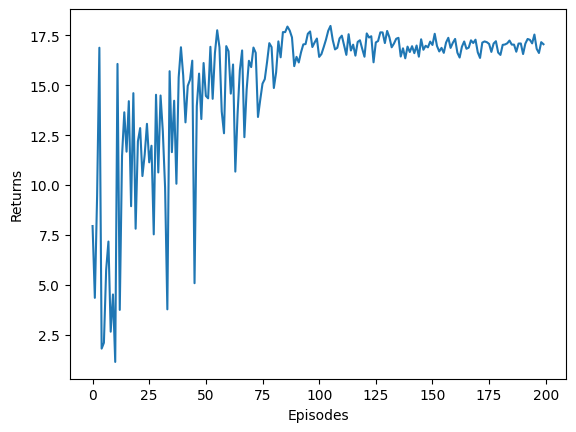

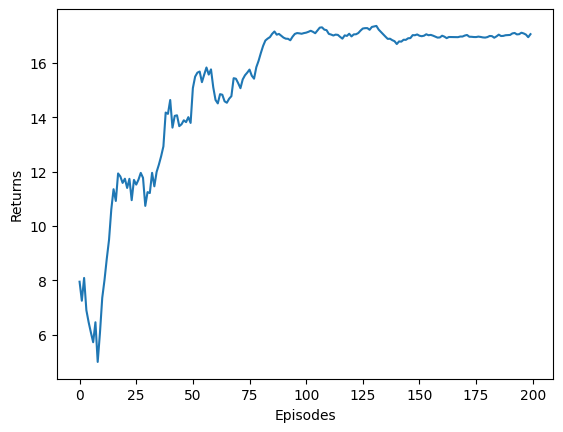

出界次数： 0


In [9]:
# 游标训练环境
import random
import matplotlib
import matplotlib.pyplot as plt
import gym
from gym import spaces
from numpy.linalg import norm
from torch.distributions import Normal
import random
import numpy as np
from tqdm import tqdm
import collections
import torch
from torch import nn
import torch.nn.functional as F

# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None
        self.out_range = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        self.out_range = 0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move # + np.random.normal()
        self.position = np.clip(self.position, self.min_pos, self.max_pos) # 栏杆

        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
            self.out_range = 1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            reward1 = 1 - np.linalg.norm(self.position - (self.max_pos + self.min_pos) / 2) / 10
        else:
            reward1 = 0 # -3
        return reward1

# 改进算法

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()

        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(torch.nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_out = torch.nn.Linear(prev_size, 1)

    def forward(self, x):
        y = self.net(x)
        return self.fc_out(y)


class SquashedNormal:
    """带 tanh 压缩的高斯分布。

    采样：u ~ N(mu, std)（使用 rsample 支持 reparam），a = tanh(u)
    log_prob：基于 u 的 normal.log_prob(u) 并加上 tanh 的 Jacobian 修正项：-sum log(1 - tanh(u)^2)
    注意：外部需要把动作缩放到环境动作空间（仿射变换）。
    """

    def __init__(self, mu, std, eps=1e-6):
        self.mu = mu
        self.std = std
        self.normal = Normal(mu, std)
        self.eps = eps

    def sample(self):
        # rsample 以支持 reparameterization 重参数化采样, 结果是可导的
        u = self.normal.rsample()
        a = torch.tanh(u)
        return a, u

    def log_prob(self, a, u):
        # a: tanh(u)
        # log_prob(u) - sum log(1 - tanh(u)^2)
        # normal.log_prob 返回每个维度的 log_prob，需要 sum
        # 为数值稳定性添加小量
        log_prob_u = self.normal.log_prob(u)
        # jacobian term
        jacobian = torch.log(1 - a.pow(2) + self.eps) # fixme 应该+还是-？
        # sum over action dim, keep dims consistent: return (N, 1)
        return (log_prob_u - jacobian).sum(-1, keepdim=True)

    def entropy(self):
        # 近似：使用 base normal 的熵之和（不考虑 tanh 的修正）
        # 这在实践中通常足够，若需精确熵可用采样估计
        ent = self.normal.entropy().sum(-1)
        return ent


class PolicyNetContinuous(torch.nn.Module):
    """输出未压缩（pre-squash）的 mu 和 std。

    网络输出的 mu 是未经过 tanh 的原始均值，std 用 softplus 保证正值。
    不在网络内部做 action scaling，统一在采样/执行阶段处理。
    """

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_mu = torch.nn.Linear(prev_size, action_dim)
        self.fc_std = torch.nn.Linear(prev_size, action_dim)

    def forward(self, x, min_std=1e-3):
        x = self.net(x)
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        std = torch.clamp(std, min=min_std)
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法，支持时变动作区间（每步 amin/amax 不同）。

    设计说明（必须注意）：
    - 如果环境的动作约束随状态变化（amin/amax 为时变），则经验回放需保存当时的
      amin/amax（请把它放到 transition_dict['action_bounds']，形状为 (N, 2) 或每步的 (amin, amax)）。
    - 如果 action_bounds 在训练时始终恒定（标量或单个区间），也可以直接把 action_bound
      作为常数传入 update()。
    - 在本实现中，策略内部输出的是标准化前的 mu 和 std（即对 u 的分布参数）。
      对应的执行动作为：a = tanh(u)  -> normalized in (-1,1)
      最后缩放到真实区间： a_exec = amin + (a+1)/2 * (amax-amin)
    - update() 中会把存储的 a_exec "反归一化" 回 normalized a（[-1,1]），以便计算 log_prob。
    '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def _scale_action_to_exec(self, a, action_bounds):
        """把 normalized action a (in [-1,1]) 缩放到环境区间。

        action_bounds 可以是：
        - 单个数值：action_bound，表示对称区间 [-action_bound, action_bound]
        - 长度为 2 的元组/列表 (amin, amax)
        - 每步的数组，形状 (N, 2)
        """
        if isinstance(action_bounds, (int, float)):
            # 对称区间
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a.dtype, device=a.device)
        amax = torch.as_tensor(amax, dtype=a.dtype, device=a.device)
        # a in (-1,1) -> scale to [amin, amax]
        return amin + (a + 1.0) * 0.5 * (amax - amin)

    def _unscale_exec_to_normalized(self, a_exec, action_bounds):
        """把执行动作 a_exec 反向归一化到 [-1,1]。

        如果 action_bounds 是标量，视作对称区间 [-b, b]。
        返回 normalized action (in (-1,1)).
        """
        if isinstance(action_bounds, (int, float)):
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a_exec.dtype, device=a_exec.device)
        amax = torch.as_tensor(amax, dtype=a_exec.dtype, device=a_exec.device)
        # 防止除以零
        span = (amax - amin)
        span = torch.where(span == 0, torch.tensor(1e-6, device=span.device, dtype=span.dtype), span)
        a = 2.0 * (a_exec - amin) / span - 1.0
        # numerical stability
        return a.clamp(-0.999999, 0.999999)

    def take_action(self, state, action_bounds=1.0, explore=True):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        dist = SquashedNormal(mu, std)
        if explore:
            a_norm, u = dist.sample()
        else:
            # use mean action: tanh(mu)
            u = mu
            a_norm = torch.tanh(u)

        # # scale to actual action bounds
        # if isinstance(action_bounds, (int, float)):
        #     amin = -float(action_bounds)
        #     amax = float(action_bounds)
        # else:
        #     amin, amax = action_bounds
        # amin = torch.as_tensor(amin, dtype=a_norm.dtype, device=a_norm.device)
        # a_exec = amin + (a_norm + 1.0) * 0.5 * (float(amax) - float(amin))
        # return a_exec[0].cpu().detach().numpy().flatten()
        # 调用 _scale_action_to_exec 进行动作缩放

        a_exec = self._scale_action_to_exec(a_norm, action_bounds)
        return a_exec[0].cpu().detach().numpy().flatten()
    


    def update(self, transition_dict, action_bounds=None):
        """更新函数兼容以下几种调用方式：
        - 如果 action_bounds 是 None：期望 transition_dict 中包含 'action_bounds'，其形状为 (N,2) 或每步 (amin,amax)
        - 如果 action_bounds 是标量/二元元组/数组：作为全局固定区间使用

        transition_dict 必须包含 keys: 'states','actions','rewards','next_states','dones'
        当动作区间随步变化时，必须包含 'action_bounds' 与之对应。
        存储的 'actions' 应当是环境执行动作 a_exec（未归一化）。
        """
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions_exec = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # # 获取每步的 action_bounds，如果外部传入了 action_bounds 参数则优先使用
        # if action_bounds is None:
        #     if 'action_bounds' not in transition_dict:
        #         action_bounds = 1.0
        #         # raise KeyError("action_bounds 未提供：当动作约束为时变时，transition_dict 必须包含 'action_bounds'")
        #     # action_bounds_arr = transition_dict['action_bounds']
        # else:
        #     # 将固定 action_bounds 扩展为每步相同的序列，方便后续计算
        #     action_bounds_arr = [action_bounds] * len(transition_dict['actions'])

        if action_bounds is None:
            if 'action_bounds' in transition_dict:
                action_bounds = transition_dict['action_bounds']
            else:
                action_bounds = 1.0  # 默认值

        # 将 action_bounds 处理为每步的数组
        if isinstance(action_bounds, (int, float)):
            # 对称区间，扩展为每步相同的区间
            # action_bounds_arr = [action_bounds] * len(transition_dict['actions'])
            amin_list = [-float(action_bounds)] * len(transition_dict['actions'])
            amax_list = [float(action_bounds)] * len(transition_dict['actions'])
        elif isinstance(action_bounds, (tuple, list, np.ndarray)) and len(action_bounds) == 2:
            # 二元元组或列表，扩展为每步相同的 min 和 max
            amin_list = [float(action_bounds[0])] * len(transition_dict['actions'])
            amax_list = [float(action_bounds[1])] * len(transition_dict['actions'])
        else:
            # 每步不同的区间，直接解包
            amin_list = [float(ab[0]) if isinstance(ab, (tuple, list, np.ndarray)) else -float(ab) for ab in action_bounds]
            amax_list = [float(ab[1]) if isinstance(ab, (tuple, list, np.ndarray)) else float(ab) for ab in action_bounds]

        # 转换为张量
        amin_tensor = torch.tensor(amin_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)
        amax_tensor = torch.tensor(amax_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)

        # # 将 action_bounds 处理为每步的数组
        # if isinstance(action_bounds, (int, float)):
        #     action_bounds_arr = [action_bounds] * len(transition_dict['actions'])
        # else:
        #     action_bounds_arr = action_bounds

        # 将 action_bounds_arr 变为 tensor，形状 (N, 2)
        # 支持传入每步为 (amin,amax) 或 标量
        # amin_list = []
        # amax_list = []
        # for ab in action_bounds_arr:
        #     if isinstance(ab, (int, float)):
        #         amin_list.append(-float(ab))
        #         amax_list.append(float(ab))
        #     else:
        #         amin_list.append(float(ab[0]))
        #         amax_list.append(float(ab[1]))
        # amin_tensor = torch.tensor(amin_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)
        # amax_tensor = torch.tensor(amax_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)

        # 计算 td_target, advantage
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # 策略输出（未压缩的 mu,std）
        mu, std = self.actor(states)
        # 构造 SquashedNormal 并计算 old_log_probs
        dist = SquashedNormal(mu.detach(), std.detach())

        # 将执行动作反向归一化到 [-1,1]，以便计算 log_prob
        # actions_normalized = 2.0 * (actions_exec - amin_tensor) / (amax_tensor - amin_tensor + 1e-8) - 1.0
        # actions_normalized = actions_normalized.clamp(-0.999999, 0.999999)
        actions_normalized = self._unscale_exec_to_normalized(actions_exec, (amin_tensor, amax_tensor))
        
        # 反算 u = atanh(a)
        u_old = torch.atanh(actions_normalized)
        old_log_probs = dist.log_prob(actions_normalized, u_old)

        if torch.isnan(old_log_probs).any():
            raise ValueError("old_log_probs 包含 NaN，检查 action_bounds 或 actions 的合法性")

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            if torch.isnan(mu).any() or torch.isnan(std).any():
                raise ValueError("NaN in Actor outputs in loop")
            critic_values = self.critic(states)
            if torch.isnan(critic_values).any():
                raise ValueError("NaN in Critic outputs in loop")

            dist = SquashedNormal(mu, std)
            # 计算当前策略对历史执行动作的 log_prob（使用同一个 u_old）
            log_probs = dist.log_prob(actions_normalized, u_old)

            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = -torch.min(surr1, surr2).mean() - 0.1 * dist.entropy().mean()

            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()

            # 梯度裁剪
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=2)
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=2)

            self.actor_optimizer.step()
            self.critic_optimizer.step()


# 注意：为了兼容原来的训练循环，请在构造 transition_dict 时保证：
# - 'actions' 存储的是环境实际执行的动作 a_exec（未归一化）
# - 如果动作区间随步变化，则 transition_dict['action_bounds'] 应为长度为步数的序列，
#   其中每个元素是 (amin, amax) 或 标量 b（表示对称区间 [-b,b]）。
# 示例：
# transition = {
#   'states': [...],
#   'actions': [...],  # 执行到环境的动作
#   'rewards': [...],
#   'next_states': [...],
#   'dones': [...],
#   'action_bounds': [(amin0,amax0), (amin1,amax1), ...]  # 可选
# }

# 以上实现把 action_bounds 纳入了 update 的计算链路，从而保证了 log_prob 的计算与当时执行动作的一致性，
# 避免了因动作裁剪/投影导致的策略-执行分布不匹配，从根本上缓解了你提到的 update 中梯度爆炸问题。


# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200 # fixme 如果不限制最小方差，500 的时候会梯度爆炸, 限制后1000 也会爆炸
hidden_dims = [128]  # 128 fixme 层数大时actor梯度也会爆炸
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1




action_bound = 3  # 动作最大值

agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)
out_range_count = 0
return_list = []
clear_batch_flag=1
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        if clear_batch_flag:
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            clear_batch_flag=0
        state = env.reset()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action = agent.take_action(state, action_bounds=action_bound, explore=True)
            next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward

        if env.out_range==1:
            out_range_count+=1

        return_list.append(episode_return)
        if 1: # len(transition_dict['dones'])>20: # 逐batch更新
            agent.update(transition_dict, action_bound)
            clear_batch_flag=1
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

# %matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))

plt.show()

print("出界次数：", out_range_count)

#### 仅使用动作重映射不使用Jacobi

Iteration:   1%|          | 2/200 [00:00<00:11, 17.39it/s]

tensor([[ 8.5778e-03],
        [-9.9087e+00],
        [ 5.2336e-01],
        [-1.0761e+00],
        [-5.6318e+00],
        [ 8.7265e-01],
        [-9.0394e+00],
        [-2.9608e+00],
        [ 4.8118e-01],
        [ 1.1732e+00],
        [ 1.0642e+00],
        [ 1.1327e+00],
        [-4.6192e-02],
        [ 1.1827e+00],
        [ 1.0579e+00],
        [ 9.5298e-01],
        [ 4.4577e-03],
        [ 1.0433e+00],
        [ 4.0641e-01],
        [ 1.1071e+00]])
tensor([[ 8.5778e-03],
        [-9.9087e+00],
        [ 5.2336e-01],
        [-1.0761e+00],
        [-5.6318e+00],
        [ 8.7265e-01],
        [-9.0394e+00],
        [-2.9608e+00],
        [ 4.8118e-01],
        [ 1.1732e+00],
        [ 1.0642e+00],
        [ 1.1327e+00],
        [-4.6192e-02],
        [ 1.1827e+00],
        [ 1.0579e+00],
        [ 9.5298e-01],
        [ 4.4577e-03],
        [ 1.0433e+00],
        [ 4.0641e-01],
        [ 1.1071e+00]], grad_fn=<SubBackward0>)
tensor([[ -0.2789],
        [-10.3441],
        [  0.7

Iteration:   4%|▍         | 8/200 [00:00<00:09, 21.33it/s]

tensor([[ 0.4568],
        [ 0.4119],
        [ 0.5047],
        [ 0.4326],
        [ 0.7026],
        [-2.5774],
        [ 0.6968],
        [ 0.7095],
        [ 0.6456],
        [ 0.7433],
        [ 0.7796],
        [ 0.6921],
        [-0.1486],
        [ 0.6819],
        [ 0.6807],
        [ 0.4651],
        [ 0.4739],
        [ 0.6388],
        [ 0.2955],
        [ 0.6192]], grad_fn=<SubBackward0>)
tensor([[ 0.3220],
        [ 0.5042],
        [-2.5467],
        [ 0.4585],
        [ 0.6646],
        [ 0.7077],
        [ 0.5734],
        [ 0.4942],
        [ 0.6761],
        [ 0.6933],
        [ 0.3347],
        [ 0.7210],
        [ 0.7437],
        [ 0.1515],
        [ 0.6939],
        [-1.6751],
        [ 0.7287],
        [-0.2178],
        [ 0.7272],
        [ 0.7440]])
tensor([[ 0.3220],
        [ 0.5042],
        [-2.5467],
        [ 0.4585],
        [ 0.6646],
        [ 0.7077],
        [ 0.5734],
        [ 0.4942],
        [ 0.6761],
        [ 0.6933],
        [ 0.3347],
     

Iteration:   6%|▌         | 12/200 [00:00<00:09, 20.52it/s, episode=13, return=8.639]

tensor([[ 0.1376],
        [-1.0333],
        [-1.5250],
        [-0.2669],
        [-0.2920],
        [ 0.1731],
        [-0.4745],
        [-0.8178],
        [ 0.0042],
        [-1.2645],
        [ 0.1558],
        [-0.5488],
        [-0.2418],
        [ 0.1821],
        [ 0.0976],
        [ 0.0899],
        [ 0.1693],
        [-0.0166],
        [ 0.0793],
        [-0.0660]], grad_fn=<SubBackward0>)
tensor([[ 0.1163],
        [-0.9692],
        [-1.4407],
        [-0.2391],
        [-0.2628],
        [ 0.1548],
        [-0.5062],
        [-0.7632],
        [ 0.0151],
        [-1.2945],
        [ 0.1359],
        [-0.5807],
        [-0.2154],
        [ 0.1752],
        [ 0.0741],
        [ 0.0940],
        [ 0.1505],
        [-0.0437],
        [ 0.0550],
        [-0.0942]], grad_fn=<SubBackward0>)
tensor([[ 0.0935],
        [-0.9067],
        [-1.3576],
        [-0.2134],
        [-0.2357],
        [ 0.1348],
        [-0.5383],
        [-0.7102],
        [ 0.0241],
        [-1.3235],


Iteration:   8%|▊         | 17/200 [00:00<00:08, 21.65it/s, episode=18, return=8.965]

tensor([[-0.8310],
        [-1.6330],
        [-1.1677],
        [-1.4138],
        [-0.5574],
        [-0.7076],
        [-0.4565],
        [-1.4991],
        [-0.5344],
        [-0.4943],
        [-1.4852],
        [-1.9883],
        [-0.6751],
        [-0.4496],
        [-0.5249],
        [-0.7875],
        [-0.5986],
        [-0.9617],
        [-0.9461],
        [-0.5963]])
tensor([[-0.8310],
        [-1.6330],
        [-1.1677],
        [-1.4138],
        [-0.5574],
        [-0.7076],
        [-0.4565],
        [-1.4991],
        [-0.5344],
        [-0.4943],
        [-1.4852],
        [-1.9883],
        [-0.6751],
        [-0.4496],
        [-0.5249],
        [-0.7875],
        [-0.5986],
        [-0.9617],
        [-0.9461],
        [-0.5963]], grad_fn=<SubBackward0>)
tensor([[-0.8219],
        [-1.5785],
        [-1.1784],
        [-1.4171],
        [-0.5824],
        [-0.7303],
        [-0.4808],
        [-1.4519],
        [-0.5456],
        [-0.5089],
        [-1.4387],
     

Iteration:  12%|█▏        | 23/200 [00:01<00:08, 21.99it/s, episode=23, return=10.916]

tensor([[-0.9492],
        [-1.3184],
        [-2.5648],
        [-0.9125],
        [-1.0136],
        [-1.5730],
        [-1.7438],
        [-1.4944],
        [-1.0493],
        [-0.9967],
        [-1.0735],
        [-1.0244],
        [-0.9806],
        [-1.3441],
        [-4.1195],
        [-1.1319],
        [-3.1165],
        [-0.8993],
        [-1.6803],
        [-1.5649]])
tensor([[-0.9492],
        [-1.3184],
        [-2.5648],
        [-0.9125],
        [-1.0136],
        [-1.5730],
        [-1.7438],
        [-1.4944],
        [-1.0493],
        [-0.9967],
        [-1.0735],
        [-1.0244],
        [-0.9806],
        [-1.3441],
        [-4.1195],
        [-1.1319],
        [-3.1165],
        [-0.8993],
        [-1.6803],
        [-1.5649]], grad_fn=<SubBackward0>)
tensor([[-0.9419],
        [-1.2978],
        [-2.5241],
        [-0.9168],
        [-1.0248],
        [-1.5469],
        [-1.7146],
        [-1.5196],
        [-1.0620],
        [-1.0071],
        [-1.0872],
     

Iteration:  14%|█▎        | 27/200 [00:01<00:07, 21.81it/s, episode=28, return=12.685]

tensor([[-21.8417],
        [ -0.7578],
        [ -4.7480],
        [ -1.4545],
        [-15.2401],
        [-48.6347],
        [-18.2143],
        [-11.4373],
        [ -2.9074],
        [ -0.6408],
        [ -0.6410],
        [ -1.3285],
        [ -1.6446],
        [ -1.1073],
        [ -0.8224],
        [ -0.9736],
        [ -1.5999],
        [ -1.3299],
        [ -0.6294],
        [ -0.7044]], grad_fn=<SubBackward0>)
tensor([[ -5.4721],
        [-27.5444],
        [-19.8110],
        [ -3.8880],
        [ -5.5341],
        [-10.6866],
        [ -1.2328],
        [ -0.7967],
        [ -1.5684],
        [ -3.2276],
        [ -0.8633],
        [ -4.9044],
        [ -4.6359],
        [ -0.9529],
        [ -0.7543],
        [ -2.5264],
        [ -2.3966],
        [ -2.5302],
        [ -0.8550],
        [ -0.9426]])
tensor([[ -5.4721],
        [-27.5444],
        [-19.8110],
        [ -3.8880],
        [ -5.5341],
        [-10.6866],
        [ -1.2328],
        [ -0.7967],
        [ -1.5

Iteration:  16%|█▌        | 31/200 [00:01<00:07, 21.89it/s, episode=32, return=14.391]

tensor([[-1.2235],
        [-9.0820],
        [-1.0746],
        [-1.0056],
        [-1.1049],
        [-1.2240],
        [-1.0884],
        [-5.0833],
        [-1.1392],
        [-2.8299],
        [-1.0794],
        [-2.6578],
        [-3.1566],
        [-1.3228],
        [-1.4562],
        [-5.5260],
        [-1.1192],
        [-1.9802],
        [-3.7114],
        [-1.2874]])
tensor([[-1.2235],
        [-9.0820],
        [-1.0746],
        [-1.0056],
        [-1.1049],
        [-1.2240],
        [-1.0884],
        [-5.0833],
        [-1.1392],
        [-2.8299],
        [-1.0794],
        [-2.6578],
        [-3.1566],
        [-1.3228],
        [-1.4562],
        [-5.5260],
        [-1.1192],
        [-1.9802],
        [-3.7114],
        [-1.2874]], grad_fn=<SubBackward0>)
tensor([[-1.2299],
        [-9.0529],
        [-1.0802],
        [-1.0097],
        [-1.1049],
        [-1.2303],
        [-1.0941],
        [-5.0387],
        [-1.1452],
        [-2.8078],
        [-1.0800],
     

Iteration:  18%|█▊        | 35/200 [00:01<00:07, 21.31it/s, episode=36, return=14.545]

tensor([[ -5.1583],
        [ -1.0992],
        [ -1.2600],
        [ -1.4112],
        [ -0.6417],
        [ -0.7904],
        [ -0.7405],
        [ -0.8398],
        [ -0.8580],
        [ -0.9550],
        [ -0.6930],
        [ -1.1932],
        [ -3.9035],
        [ -3.1677],
        [-10.2488],
        [ -2.1004],
        [-48.6838],
        [ -5.6058],
        [ -1.9620],
        [ -5.9219]])
tensor([[ -5.1583],
        [ -1.0992],
        [ -1.2600],
        [ -1.4112],
        [ -0.6417],
        [ -0.7904],
        [ -0.7405],
        [ -0.8398],
        [ -0.8580],
        [ -0.9550],
        [ -0.6930],
        [ -1.1932],
        [ -3.9035],
        [ -3.1677],
        [-10.2488],
        [ -2.1004],
        [-48.6838],
        [ -5.6058],
        [ -1.9620],
        [ -5.9219]], grad_fn=<SubBackward0>)
tensor([[ -5.1392],
        [ -1.1004],
        [ -1.2582],
        [ -1.4087],
        [ -0.6434],
        [ -0.7910],
        [ -0.7425],
        [ -0.8416],
        [ -0.8

Iteration:  20%|██        | 40/200 [00:01<00:07, 21.67it/s, episode=41, return=15.194]

tensor([[-5.8069],
        [-1.0439],
        [-0.9535],
        [-2.7906],
        [-2.3403],
        [-0.9628],
        [-1.0118],
        [-1.3409],
        [-1.1390],
        [-1.1977],
        [-1.8862],
        [-3.2925],
        [-1.0011],
        [-1.4245],
        [-1.0778],
        [-1.1036],
        [-1.0787],
        [-0.9673],
        [-0.9896],
        [-1.8594]], grad_fn=<SubBackward0>)
tensor([[-5.7674],
        [-1.0480],
        [-0.9569],
        [-2.7763],
        [-2.3299],
        [-0.9668],
        [-1.0159],
        [-1.3397],
        [-1.1428],
        [-1.1979],
        [-1.8798],
        [-3.2839],
        [-1.0036],
        [-1.4224],
        [-1.0818],
        [-1.1075],
        [-1.0802],
        [-0.9704],
        [-0.9924],
        [-1.8533]], grad_fn=<SubBackward0>)
tensor([[-5.7257],
        [-1.0523],
        [-0.9606],
        [-2.7611],
        [-2.3188],
        [-0.9711],
        [-1.0203],
        [-1.3384],
        [-1.1467],
        [-1.1982],


Iteration:  22%|██▏       | 44/200 [00:02<00:07, 21.85it/s, episode=45, return=16.200]

tensor([[ -2.6220],
        [ -1.1160],
        [ -1.2851],
        [ -1.4730],
        [ -1.0537],
        [ -1.4813],
        [ -0.9236],
        [ -0.7713],
        [ -1.6275],
        [ -0.8260],
        [ -0.9115],
        [ -0.7789],
        [ -1.8780],
        [ -0.7507],
        [ -0.7573],
        [-23.1604],
        [ -2.8380],
        [ -1.0716],
        [ -3.0320],
        [ -1.2963]])
tensor([[ -2.6220],
        [ -1.1160],
        [ -1.2851],
        [ -1.4730],
        [ -1.0537],
        [ -1.4813],
        [ -0.9236],
        [ -0.7713],
        [ -1.6275],
        [ -0.8260],
        [ -0.9115],
        [ -0.7789],
        [ -1.8780],
        [ -0.7507],
        [ -0.7573],
        [-23.1604],
        [ -2.8380],
        [ -1.0716],
        [ -3.0320],
        [ -1.2963]], grad_fn=<SubBackward0>)
tensor([[ -2.6198],
        [ -1.1155],
        [ -1.2861],
        [ -1.4710],
        [ -1.0552],
        [ -1.4792],
        [ -0.9240],
        [ -0.7731],
        [ -1.6

Iteration:  25%|██▌       | 50/200 [00:02<00:06, 22.32it/s, episode=50, return=16.005]

tensor([[-4.3714],
        [-3.3802],
        [-4.6528],
        [-4.7906],
        [-1.7983],
        [-2.0971],
        [-3.6273],
        [-1.9330],
        [-1.7734],
        [-2.2285],
        [-1.7656],
        [-2.0767],
        [-1.9249],
        [-2.2046],
        [-1.7553],
        [-2.8857],
        [-2.5984],
        [-1.7450],
        [-2.0887],
        [-2.3477]])
tensor([[-4.3714],
        [-3.3802],
        [-4.6528],
        [-4.7906],
        [-1.7983],
        [-2.0971],
        [-3.6273],
        [-1.9330],
        [-1.7734],
        [-2.2285],
        [-1.7656],
        [-2.0767],
        [-1.9249],
        [-2.2046],
        [-1.7553],
        [-2.8857],
        [-2.5984],
        [-1.7450],
        [-2.0887],
        [-2.3477]], grad_fn=<SubBackward0>)
tensor([[-4.3816],
        [-3.3942],
        [-4.6649],
        [-4.8035],
        [-1.7939],
        [-2.0983],
        [-3.6436],
        [-1.9288],
        [-1.7691],
        [-2.2312],
        [-1.7624],
     

Iteration:  26%|██▋       | 53/200 [00:02<00:06, 21.11it/s, episode=54, return=16.316]

tensor([[ -1.0122],
        [ -9.5296],
        [ -0.7587],
        [ -1.8738],
        [ -0.7822],
        [ -2.9651],
        [ -1.1892],
        [ -1.0519],
        [ -4.1982],
        [ -0.7484],
        [ -0.7492],
        [-43.8904],
        [ -5.8497],
        [ -0.9326],
        [ -0.8280],
        [ -2.3563],
        [ -0.7460],
        [ -1.9801],
        [ -1.0927],
        [ -0.8178]])
tensor([[ -1.0122],
        [ -9.5296],
        [ -0.7587],
        [ -1.8738],
        [ -0.7822],
        [ -2.9651],
        [ -1.1892],
        [ -1.0519],
        [ -4.1982],
        [ -0.7484],
        [ -0.7492],
        [-43.8904],
        [ -5.8497],
        [ -0.9326],
        [ -0.8280],
        [ -2.3563],
        [ -0.7460],
        [ -1.9801],
        [ -1.0927],
        [ -0.8178]], grad_fn=<SubBackward0>)
tensor([[ -1.0110],
        [ -9.5200],
        [ -0.7602],
        [ -1.8759],
        [ -0.7827],
        [ -2.9660],
        [ -1.1871],
        [ -1.0505],
        [ -4.1

Iteration:  29%|██▉       | 58/200 [00:02<00:06, 21.13it/s, episode=59, return=17.038]

tensor([[ -5.9164],
        [ -3.6684],
        [ -1.1510],
        [ -1.0355],
        [ -0.8623],
        [ -0.8640],
        [ -1.8078],
        [ -0.7492],
        [ -1.5417],
        [ -7.5411],
        [ -0.8257],
        [-11.3876],
        [ -0.7320],
        [ -0.8383],
        [ -0.9490],
        [ -1.5059],
        [-27.0875],
        [ -0.7886],
        [ -0.7195],
        [ -1.2328]], grad_fn=<SubBackward0>)
tensor([[-11.9971],
        [ -1.0918],
        [ -3.6872],
        [ -1.2459],
        [ -2.9516],
        [ -2.0000],
        [ -1.1272],
        [ -1.7270],
        [ -1.0895],
        [ -2.0626],
        [ -1.6053],
        [ -1.2141],
        [ -1.0854],
        [ -1.8402],
        [ -2.5031],
        [ -1.2538],
        [ -1.4936],
        [ -1.3741],
        [ -1.5986],
        [ -5.9105]])
tensor([[-11.9971],
        [ -1.0918],
        [ -3.6872],
        [ -1.2459],
        [ -2.9516],
        [ -2.0000],
        [ -1.1272],
        [ -1.7270],
        [ -1.0

Iteration:  31%|███       | 62/200 [00:02<00:06, 21.66it/s, episode=63, return=17.018]

tensor([[ -1.5244],
        [ -2.7247],
        [ -2.5613],
        [ -0.9405],
        [ -3.2555],
        [ -0.9169],
        [ -1.7711],
        [ -1.2227],
        [ -1.7689],
        [ -2.3157],
        [ -2.3219],
        [ -2.6844],
        [ -1.3472],
        [ -2.1912],
        [ -1.0860],
        [ -1.3887],
        [-21.7769],
        [ -1.5958],
        [ -0.7837],
        [-18.1753]])
tensor([[ -1.5244],
        [ -2.7247],
        [ -2.5613],
        [ -0.9405],
        [ -3.2555],
        [ -0.9169],
        [ -1.7711],
        [ -1.2227],
        [ -1.7689],
        [ -2.3157],
        [ -2.3219],
        [ -2.6844],
        [ -1.3472],
        [ -2.1912],
        [ -1.0860],
        [ -1.3887],
        [-21.7769],
        [ -1.5958],
        [ -0.7837],
        [-18.1753]], grad_fn=<SubBackward0>)
tensor([[ -1.5202],
        [ -2.7167],
        [ -2.5654],
        [ -0.9428],
        [ -3.2460],
        [ -0.9192],
        [ -1.7748],
        [ -1.2198],
        [ -1.7

Iteration:  34%|███▎      | 67/200 [00:03<00:06, 21.64it/s, episode=68, return=16.910]

tensor([[-9.6694],
        [-1.1787],
        [-2.0260],
        [-2.1196],
        [-3.9479],
        [-1.5545],
        [-1.9213],
        [-2.3776],
        [-1.4325],
        [-1.7976],
        [-1.0528],
        [-1.9840],
        [-1.1233],
        [-1.6775],
        [-1.0170],
        [-1.1989],
        [-1.1249],
        [-1.1428],
        [-5.5644],
        [-1.5947]], grad_fn=<SubBackward0>)
tensor([[-9.7263],
        [-1.1736],
        [-2.0372],
        [-2.1316],
        [-3.9725],
        [-1.5480],
        [-1.9317],
        [-2.3916],
        [-1.4264],
        [-1.8069],
        [-1.0487],
        [-1.9949],
        [-1.1255],
        [-1.6858],
        [-1.0172],
        [-1.2021],
        [-1.1271],
        [-1.1452],
        [-5.5988],
        [-1.6022]], grad_fn=<SubBackward0>)
tensor([[-9.7865],
        [-1.1682],
        [-2.0494],
        [-2.1445],
        [-3.9988],
        [-1.5410],
        [-1.9429],
        [-2.4066],
        [-1.4197],
        [-1.8170],


Iteration:  36%|███▌      | 71/200 [00:03<00:06, 21.36it/s, episode=72, return=17.129]

tensor([[-0.9636],
        [-2.9801],
        [-0.9557],
        [-2.3023],
        [-1.1981],
        [-1.3666],
        [-1.6564],
        [-1.1892],
        [-1.0011],
        [-3.4859],
        [-0.9706],
        [-0.9700],
        [-2.4285],
        [-1.2299],
        [-1.1845],
        [-1.0508],
        [-1.6064],
        [-0.9405],
        [-2.6482],
        [-1.7253]])
tensor([[-0.9636],
        [-2.9801],
        [-0.9557],
        [-2.3023],
        [-1.1981],
        [-1.3666],
        [-1.6564],
        [-1.1892],
        [-1.0011],
        [-3.4859],
        [-0.9706],
        [-0.9700],
        [-2.4285],
        [-1.2299],
        [-1.1845],
        [-1.0508],
        [-1.6064],
        [-0.9405],
        [-2.6482],
        [-1.7253]], grad_fn=<SubBackward0>)
tensor([[-0.9640],
        [-2.9844],
        [-0.9563],
        [-2.3070],
        [-1.1957],
        [-1.3707],
        [-1.6609],
        [-1.1929],
        [-1.0008],
        [-3.4899],
        [-0.9730],
     

Iteration:  38%|███▊      | 77/200 [00:03<00:05, 21.86it/s, episode=77, return=17.053]

tensor([[-45.6933],
        [ -2.9618],
        [ -0.7553],
        [ -2.8270],
        [ -2.1461],
        [ -5.6963],
        [ -0.7603],
        [ -1.4264],
        [ -0.6997],
        [ -0.7014],
        [ -2.9091],
        [ -0.8245],
        [ -1.3957],
        [ -0.8753],
        [ -0.8428],
        [ -1.8290],
        [ -0.6968],
        [ -1.6521],
        [ -2.2221],
        [ -6.3250]])
tensor([[-45.6933],
        [ -2.9618],
        [ -0.7553],
        [ -2.8270],
        [ -2.1461],
        [ -5.6963],
        [ -0.7603],
        [ -1.4264],
        [ -0.6997],
        [ -0.7014],
        [ -2.9091],
        [ -0.8245],
        [ -1.3957],
        [ -0.8753],
        [ -0.8428],
        [ -1.8290],
        [ -0.6968],
        [ -1.6521],
        [ -2.2221],
        [ -6.3250]], grad_fn=<SubBackward0>)
tensor([[-45.7244],
        [ -2.9639],
        [ -0.7552],
        [ -2.8290],
        [ -2.1475],
        [ -5.6974],
        [ -0.7598],
        [ -1.4271],
        [ -0.6

Iteration:  40%|████      | 81/200 [00:03<00:05, 21.94it/s, episode=82, return=17.029]

tensor([[-5.6581],
        [-0.8653],
        [-2.6891],
        [-1.8956],
        [-1.9507],
        [-1.6211],
        [-1.2185],
        [-1.1608],
        [-0.9756],
        [-0.8733],
        [-2.6648],
        [-6.1167],
        [-2.2365],
        [-6.5141],
        [-3.5865],
        [-1.4967],
        [-3.7837],
        [-1.4366],
        [-0.8999],
        [-1.4301]])
tensor([[-5.6581],
        [-0.8653],
        [-2.6891],
        [-1.8956],
        [-1.9507],
        [-1.6211],
        [-1.2185],
        [-1.1608],
        [-0.9756],
        [-0.8733],
        [-2.6648],
        [-6.1167],
        [-2.2365],
        [-6.5141],
        [-3.5865],
        [-1.4967],
        [-3.7837],
        [-1.4366],
        [-0.8999],
        [-1.4301]], grad_fn=<SubBackward0>)
tensor([[-5.6609],
        [-0.8650],
        [-2.6898],
        [-1.8962],
        [-1.9510],
        [-1.6214],
        [-1.2184],
        [-1.1606],
        [-0.9753],
        [-0.8730],
        [-2.6656],
     

Iteration:  43%|████▎     | 86/200 [00:04<00:05, 22.17it/s, episode=87, return=17.337]

tensor([[ -0.6486],
        [ -5.2761],
        [ -0.6273],
        [ -7.6223],
        [ -2.4974],
        [ -1.2138],
        [ -4.9588],
        [ -0.9097],
        [ -0.9898],
        [-11.9913],
        [ -5.0971],
        [ -3.5922],
        [ -1.3749],
        [ -0.9953],
        [ -2.4322],
        [ -1.1637],
        [ -8.8286],
        [ -0.6355],
        [ -4.0692],
        [ -0.7995]], grad_fn=<SubBackward0>)
tensor([[-11.3224],
        [ -3.5371],
        [ -0.7994],
        [ -0.8607],
        [ -1.7837],
        [-26.4758],
        [ -6.1343],
        [ -0.7269],
        [ -0.7735],
        [-15.3018],
        [ -0.6673],
        [ -1.1483],
        [ -0.6667],
        [ -0.9675],
        [ -0.6746],
        [ -7.5564],
        [ -0.7993],
        [ -1.6019],
        [ -1.3132],
        [ -8.9395]])
tensor([[-11.3224],
        [ -3.5371],
        [ -0.7994],
        [ -0.8607],
        [ -1.7837],
        [-26.4758],
        [ -6.1343],
        [ -0.7269],
        [ -0.7

Iteration:  46%|████▌     | 91/200 [00:04<00:05, 21.19it/s, episode=92, return=17.355]

tensor([[-36.8701],
        [ -3.2768],
        [ -0.9838],
        [ -1.6425],
        [ -1.6362],
        [ -3.3021],
        [ -0.6711],
        [ -5.3329],
        [ -0.6466],
        [-14.2212],
        [ -0.6467],
        [ -1.3215],
        [ -6.8222],
        [ -4.1252],
        [ -8.6201],
        [ -1.7380],
        [ -0.6384],
        [-32.0392],
        [ -0.7537],
        [ -3.4417]], grad_fn=<SubBackward0>)
tensor([[-36.8959],
        [ -3.2770],
        [ -0.9830],
        [ -1.6419],
        [ -1.6357],
        [ -3.3024],
        [ -0.6709],
        [ -5.3345],
        [ -0.6463],
        [-14.2292],
        [ -0.6462],
        [ -1.3208],
        [ -6.8248],
        [ -4.1260],
        [ -8.6295],
        [ -1.7375],
        [ -0.6379],
        [-32.0611],
        [ -0.7530],
        [ -3.4421]], grad_fn=<SubBackward0>)
tensor([[-36.8772],
        [ -3.2743],
        [ -0.9823],
        [ -1.6405],
        [ -1.6343],
        [ -3.2996],
        [ -0.6713],
        [ 

Iteration:  48%|████▊     | 95/200 [00:04<00:04, 21.79it/s, episode=96, return=17.301]

tensor([[-12.4270],
        [ -0.8289],
        [ -2.5455],
        [ -2.0970],
        [ -1.9379],
        [ -3.8498],
        [ -3.2668],
        [ -0.8620],
        [ -0.8320],
        [ -2.8047],
        [-17.1492],
        [ -1.0608],
        [ -1.8054],
        [ -1.1786],
        [ -1.2219],
        [ -1.2803],
        [ -1.5025],
        [ -1.4612],
        [ -2.5188],
        [ -1.9938]])
tensor([[-12.4270],
        [ -0.8289],
        [ -2.5455],
        [ -2.0970],
        [ -1.9379],
        [ -3.8498],
        [ -3.2668],
        [ -0.8620],
        [ -0.8320],
        [ -2.8047],
        [-17.1492],
        [ -1.0608],
        [ -1.8054],
        [ -1.1786],
        [ -1.2219],
        [ -1.2803],
        [ -1.5025],
        [ -1.4612],
        [ -2.5188],
        [ -1.9938]], grad_fn=<SubBackward0>)
tensor([[-12.4231],
        [ -0.8289],
        [ -2.5437],
        [ -2.0954],
        [ -1.9396],
        [ -3.8527],
        [ -3.2647],
        [ -0.8616],
        [ -0.8

Iteration:  50%|█████     | 100/200 [00:04<00:04, 20.95it/s, episode=101, return=17.361]

tensor([[-31.9552],
        [ -0.9621],
        [ -2.9423],
        [ -1.1947],
        [ -1.3245],
        [ -3.4134],
        [ -2.7263],
        [ -1.6421],
        [ -3.6620],
        [ -1.0971],
        [ -0.8445],
        [ -0.9127],
        [ -4.2023],
        [ -1.6853],
        [ -2.9412],
        [ -1.4401],
        [ -2.9482],
        [ -8.5623],
        [ -1.9161],
        [-25.5884]], grad_fn=<SubBackward0>)
tensor([[-34.5423],
        [-41.0943],
        [ -4.6230],
        [ -3.0288],
        [ -0.8887],
        [ -0.6966],
        [ -2.7301],
        [ -1.5013],
        [ -6.4631],
        [ -0.7842],
        [ -2.8612],
        [ -6.5693],
        [ -0.7023],
        [-14.7949],
        [ -0.7212],
        [ -3.0220],
        [ -2.6654],
        [ -1.6514],
        [ -0.7020],
        [ -1.3936]])
tensor([[-34.5423],
        [-41.0943],
        [ -4.6230],
        [ -3.0288],
        [ -0.8887],
        [ -0.6966],
        [ -2.7301],
        [ -1.5013],
        [ -6.4

Iteration:  52%|█████▏    | 104/200 [00:04<00:04, 20.74it/s, episode=105, return=17.443]

tensor([[-11.1100],
        [ -5.9626],
        [ -1.8404],
        [ -5.0115],
        [ -3.4813],
        [ -2.1616],
        [ -1.0082],
        [ -2.0989],
        [ -1.0468],
        [ -7.2342],
        [ -7.1118],
        [ -1.9328],
        [ -1.6780],
        [ -1.8728],
        [ -4.6658],
        [ -3.3934],
        [ -1.6785],
        [ -1.1843],
        [ -1.1502],
        [ -6.5890]])
tensor([[-11.1100],
        [ -5.9626],
        [ -1.8404],
        [ -5.0115],
        [ -3.4813],
        [ -2.1616],
        [ -1.0082],
        [ -2.0989],
        [ -1.0468],
        [ -7.2342],
        [ -7.1118],
        [ -1.9328],
        [ -1.6780],
        [ -1.8728],
        [ -4.6658],
        [ -3.3934],
        [ -1.6785],
        [ -1.1843],
        [ -1.1502],
        [ -6.5890]], grad_fn=<SubBackward0>)
tensor([[-11.1033],
        [ -5.9598],
        [ -1.8404],
        [ -5.0080],
        [ -3.4802],
        [ -2.1607],
        [ -1.0087],
        [ -2.0988],
        [ -1.0

Iteration:  54%|█████▍    | 108/200 [00:05<00:04, 21.05it/s, episode=109, return=17.437]

tensor([[-1.6665],
        [-3.4530],
        [-3.0029],
        [-5.0298],
        [-1.3250],
        [-8.9897],
        [-2.3072],
        [-2.9733],
        [-6.9760],
        [-1.2290],
        [-6.3022],
        [-1.1099],
        [-6.8971],
        [-1.7865],
        [-4.2569],
        [-1.2019],
        [-6.5007],
        [-2.4175],
        [-3.1289],
        [-3.7704]])
tensor([[-1.6665],
        [-3.4530],
        [-3.0029],
        [-5.0298],
        [-1.3250],
        [-8.9897],
        [-2.3072],
        [-2.9733],
        [-6.9760],
        [-1.2290],
        [-6.3022],
        [-1.1099],
        [-6.8971],
        [-1.7865],
        [-4.2569],
        [-1.2019],
        [-6.5007],
        [-2.4175],
        [-3.1289],
        [-3.7704]], grad_fn=<SubBackward0>)
tensor([[-1.6654],
        [-3.4586],
        [-3.0031],
        [-5.0388],
        [-1.3253],
        [-9.0069],
        [-2.3067],
        [-2.9779],
        [-6.9891],
        [-1.2289],
        [-6.3139],
     

Iteration:  56%|█████▋    | 113/200 [00:05<00:04, 20.84it/s, episode=114, return=17.407]

tensor([[-13.1161],
        [ -4.0147],
        [ -6.8580],
        [ -2.5151],
        [ -7.8326],
        [ -3.4254],
        [-10.0127],
        [ -1.1683],
        [ -9.7951],
        [ -3.5725],
        [ -4.3837],
        [ -3.3900],
        [-11.6684],
        [ -1.3494],
        [ -7.0122],
        [ -2.4125],
        [ -9.9367],
        [ -2.4659],
        [ -9.4049],
        [ -5.2277]])
tensor([[-13.1161],
        [ -4.0147],
        [ -6.8580],
        [ -2.5151],
        [ -7.8326],
        [ -3.4254],
        [-10.0127],
        [ -1.1683],
        [ -9.7951],
        [ -3.5725],
        [ -4.3837],
        [ -3.3900],
        [-11.6684],
        [ -1.3494],
        [ -7.0122],
        [ -2.4125],
        [ -9.9367],
        [ -2.4659],
        [ -9.4049],
        [ -5.2277]], grad_fn=<SubBackward0>)
tensor([[-13.1995],
        [ -4.0335],
        [ -6.8973],
        [ -2.5229],
        [ -7.8788],
        [ -3.4400],
        [-10.0743],
        [ -1.1649],
        [ -9.8

Iteration:  58%|█████▊    | 117/200 [00:05<00:03, 20.97it/s, episode=118, return=17.175]

tensor([[ -1.7624],
        [ -1.7624],
        [ -2.3921],
        [-11.6802],
        [ -4.4612],
        [-15.4028],
        [ -1.7454],
        [-13.5579],
        [ -3.1227],
        [ -9.1444],
        [ -6.9032],
        [-10.2052],
        [ -9.7209],
        [ -1.5037],
        [-11.0964],
        [ -2.5853],
        [-12.7789],
        [ -2.7019],
        [ -9.9386],
        [-12.5418]])
tensor([[ -1.7624],
        [ -1.7624],
        [ -2.3921],
        [-11.6802],
        [ -4.4612],
        [-15.4028],
        [ -1.7454],
        [-13.5579],
        [ -3.1227],
        [ -9.1444],
        [ -6.9032],
        [-10.2052],
        [ -9.7209],
        [ -1.5037],
        [-11.0964],
        [ -2.5853],
        [-12.7789],
        [ -2.7019],
        [ -9.9386],
        [-12.5418]], grad_fn=<SubBackward0>)
tensor([[ -1.7612],
        [ -1.7612],
        [ -2.3943],
        [-11.6889],
        [ -4.4653],
        [-15.4134],
        [ -1.7466],
        [-13.5676],
        [ -3.1

Iteration:  61%|██████    | 122/200 [00:05<00:03, 21.60it/s, episode=123, return=17.071]

tensor([[-19.9014],
        [-10.3863],
        [ -1.9661],
        [ -5.6436],
        [ -2.9907],
        [ -4.1978],
        [ -1.0017],
        [ -7.9866],
        [ -2.7457],
        [ -6.4637],
        [ -0.9762],
        [ -4.7755],
        [ -1.1264],
        [-11.5684],
        [ -1.2204],
        [ -7.2057],
        [ -0.9869],
        [ -6.4060],
        [ -1.0695],
        [ -8.2747]], grad_fn=<SubBackward0>)
tensor([[-19.8646],
        [-10.3750],
        [ -1.9710],
        [ -5.6431],
        [ -2.9758],
        [ -4.2001],
        [ -1.0023],
        [ -7.9810],
        [ -2.7323],
        [ -6.4615],
        [ -0.9782],
        [ -4.7768],
        [ -1.1250],
        [-11.5541],
        [ -1.2180],
        [ -7.2019],
        [ -0.9879],
        [ -6.4039],
        [ -1.0689],
        [ -8.2684]], grad_fn=<SubBackward0>)
tensor([[-19.8162],
        [-10.3579],
        [ -1.9755],
        [ -5.6400],
        [ -2.9602],
        [ -4.2006],
        [ -1.0033],
        [ 

Iteration:  63%|██████▎   | 126/200 [00:05<00:03, 21.78it/s, episode=127, return=17.101]

tensor([[-79.0522],
        [ -1.6844],
        [-60.4089],
        [ -0.7658],
        [-14.9938],
        [ -1.4902],
        [-34.5956],
        [ -0.9078],
        [-12.2485],
        [ -2.4227],
        [ -0.8339],
        [-12.6416],
        [ -1.5162],
        [-11.4612],
        [ -0.9609],
        [-25.3993],
        [ -0.6582],
        [-28.8413],
        [ -0.6414],
        [-31.8771]])
tensor([[-79.0522],
        [ -1.6844],
        [-60.4089],
        [ -0.7658],
        [-14.9938],
        [ -1.4902],
        [-34.5956],
        [ -0.9078],
        [-12.2485],
        [ -2.4227],
        [ -0.8339],
        [-12.6416],
        [ -1.5162],
        [-11.4612],
        [ -0.9609],
        [-25.3993],
        [ -0.6582],
        [-28.8413],
        [ -0.6414],
        [-31.8771]], grad_fn=<SubBackward0>)
tensor([[-79.1401],
        [ -1.6857],
        [-60.4764],
        [ -0.7652],
        [-15.0108],
        [ -1.4912],
        [-34.6347],
        [ -0.9079],
        [-12.2

Iteration:  66%|██████▌   | 131/200 [00:06<00:03, 21.57it/s, episode=131, return=17.326]

tensor([[-12.9951],
        [ -3.8584],
        [ -0.9872],
        [ -7.2706],
        [ -1.4763],
        [ -9.9100],
        [ -0.9730],
        [ -8.3254],
        [ -1.1762],
        [ -8.2826],
        [ -1.7857],
        [ -5.9684],
        [ -1.6027],
        [ -8.3231],
        [ -1.2678],
        [ -6.1310],
        [ -2.3507],
        [ -8.9031],
        [ -1.5615],
        [ -6.9503]])
tensor([[-12.9951],
        [ -3.8584],
        [ -0.9872],
        [ -7.2706],
        [ -1.4763],
        [ -9.9100],
        [ -0.9730],
        [ -8.3254],
        [ -1.1762],
        [ -8.2826],
        [ -1.7857],
        [ -5.9684],
        [ -1.6027],
        [ -8.3231],
        [ -1.2678],
        [ -6.1310],
        [ -2.3507],
        [ -8.9031],
        [ -1.5615],
        [ -6.9503]], grad_fn=<SubBackward0>)
tensor([[-12.9729],
        [ -3.8659],
        [ -0.9868],
        [ -7.2806],
        [ -1.4728],
        [ -9.9213],
        [ -0.9732],
        [ -8.3360],
        [ -1.1

Iteration:  68%|██████▊   | 135/200 [00:06<00:03, 21.57it/s, episode=136, return=17.312]

tensor([[ -1.1778],
        [-14.6150],
        [ -1.8451],
        [ -9.7808],
        [ -0.7713],
        [-27.1937],
        [ -0.6947],
        [-23.6817],
        [ -1.6911],
        [-28.7965],
        [ -1.3842],
        [ -9.6702],
        [ -2.5024],
        [-18.2681],
        [ -0.6071],
        [-10.7215],
        [ -2.2086],
        [-10.3557],
        [ -0.9266],
        [-32.1795]], grad_fn=<SubBackward0>)
tensor([[ -1.1715],
        [-14.6942],
        [ -1.8380],
        [ -9.8371],
        [ -0.7737],
        [-27.3284],
        [ -0.6907],
        [-23.8013],
        [ -1.6841],
        [-28.9382],
        [ -1.3775],
        [ -9.7260],
        [ -2.5192],
        [-18.3638],
        [ -0.6049],
        [-10.7823],
        [ -2.2234],
        [-10.4148],
        [ -0.9310],
        [-32.3355]], grad_fn=<SubBackward0>)
tensor([[ -1.1651],
        [-14.7452],
        [ -1.8294],
        [ -9.8753],
        [ -0.7768],
        [-27.4090],
        [ -0.6875],
        [-

Iteration:  70%|███████   | 140/200 [00:06<00:02, 21.84it/s, episode=140, return=17.125]

tensor([[-73.5234],
        [-73.5234],
        [-73.5234],
        [ -7.0199],
        [ -6.1228],
        [ -3.1877],
        [ -3.6209],
        [ -3.8758],
        [ -6.9553],
        [ -1.2878],
        [-18.7157],
        [ -2.1565],
        [ -5.9821],
        [ -0.6658],
        [-44.3289],
        [ -3.3286],
        [ -3.4180],
        [-26.5249],
        [ -0.9725],
        [ -8.8855]])
tensor([[-73.5234],
        [-73.5234],
        [-73.5234],
        [ -7.0199],
        [ -6.1228],
        [ -3.1877],
        [ -3.6209],
        [ -3.8758],
        [ -6.9553],
        [ -1.2878],
        [-18.7157],
        [ -2.1565],
        [ -5.9821],
        [ -0.6658],
        [-44.3289],
        [ -3.3286],
        [ -3.4180],
        [-26.5249],
        [ -0.9725],
        [ -8.8855]], grad_fn=<SubBackward0>)
tensor([[-73.7591],
        [-73.7591],
        [-73.7591],
        [ -7.0460],
        [ -6.1457],
        [ -3.1873],
        [ -3.6344],
        [ -3.8903],
        [ -6.9

Iteration:  72%|███████▏  | 143/200 [00:06<00:02, 21.78it/s, episode=144, return=17.003]

tensor([[-26.7117],
        [-26.7117],
        [ -1.3807],
        [ -2.1670],
        [-25.4885],
        [ -1.0673],
        [-15.1789],
        [ -1.3974],
        [-28.9445],
        [ -0.6492],
        [-10.8470],
        [ -1.6113],
        [ -0.8371],
        [-70.0797],
        [ -1.4577],
        [-42.5812],
        [ -0.7928],
        [-18.9683],
        [ -1.2321],
        [-14.1967]])
tensor([[-26.7117],
        [-26.7117],
        [ -1.3807],
        [ -2.1670],
        [-25.4885],
        [ -1.0673],
        [-15.1789],
        [ -1.3974],
        [-28.9445],
        [ -0.6492],
        [-10.8470],
        [ -1.6113],
        [ -0.8371],
        [-70.0797],
        [ -1.4577],
        [-42.5812],
        [ -0.7928],
        [-18.9683],
        [ -1.2321],
        [-14.1967]], grad_fn=<SubBackward0>)
tensor([[-26.8036],
        [-26.8036],
        [ -1.3734],
        [ -2.1852],
        [-25.6753],
        [ -1.0604],
        [-15.2961],
        [ -1.3901],
        [-29.1

Iteration:  74%|███████▍  | 148/200 [00:06<00:02, 21.40it/s, episode=149, return=16.925]

tensor([[-43.1315],
        [-43.1315],
        [-25.2389],
        [-10.2810],
        [ -1.4591],
        [ -4.9466],
        [ -6.0454],
        [ -1.0709],
        [-21.1507],
        [ -3.4632],
        [-12.7576],
        [ -1.5772],
        [ -7.0486],
        [ -1.1542],
        [-10.9123],
        [ -1.1278],
        [-11.0257],
        [ -2.6336],
        [ -8.4755],
        [ -4.9672]], grad_fn=<SubBackward0>)
tensor([[-16.0187],
        [ -2.3872],
        [ -5.5210],
        [ -0.9846],
        [ -4.6179],
        [ -0.9904],
        [ -8.3106],
        [ -3.7462],
        [ -7.7611],
        [ -2.9045],
        [ -7.7915],
        [ -2.4179],
        [ -2.7702],
        [ -6.4995],
        [-15.3640],
        [ -2.1092],
        [ -0.9858],
        [ -4.5922],
        [ -1.3984],
        [ -5.4880]])
tensor([[-16.0187],
        [ -2.3872],
        [ -5.5210],
        [ -0.9846],
        [ -4.6179],
        [ -0.9904],
        [ -8.3106],
        [ -3.7462],
        [ -7.7

Iteration:  76%|███████▌  | 152/200 [00:07<00:02, 21.87it/s, episode=153, return=17.012]

tensor([[ -1.4267],
        [-42.6861],
        [ -0.7144],
        [-33.3275],
        [ -1.7746],
        [-16.5464],
        [ -1.3787],
        [-18.9990],
        [ -0.8234],
        [-29.9084],
        [ -0.7013],
        [-18.5898],
        [ -1.0502],
        [-22.7970],
        [ -0.8309],
        [-28.9886],
        [ -1.2602],
        [-26.9351],
        [ -1.9210],
        [-15.3722]])
tensor([[ -1.4267],
        [-42.6861],
        [ -0.7144],
        [-33.3275],
        [ -1.7746],
        [-16.5464],
        [ -1.3787],
        [-18.9990],
        [ -0.8234],
        [-29.9084],
        [ -0.7013],
        [-18.5898],
        [ -1.0502],
        [-22.7970],
        [ -0.8309],
        [-28.9886],
        [ -1.2602],
        [-26.9351],
        [ -1.9210],
        [-15.3722]], grad_fn=<SubBackward0>)
tensor([[ -1.4312],
        [-42.7174],
        [ -0.7154],
        [-33.3553],
        [ -1.7800],
        [-16.5661],
        [ -1.3830],
        [-19.0201],
        [ -0.8

Iteration:  78%|███████▊  | 157/200 [00:07<00:02, 21.36it/s, episode=158, return=16.956]

tensor([[ -7.0959],
        [ -7.0959],
        [ -7.0959],
        [ -4.0158],
        [-13.1348],
        [ -1.4852],
        [ -6.4885],
        [-14.0005],
        [ -4.0060],
        [-10.6145],
        [ -3.3721],
        [-10.8021],
        [ -1.4286],
        [-10.9106],
        [ -1.3474],
        [-23.9311],
        [ -1.4088],
        [-13.3964],
        [ -2.8747],
        [-11.1014]], grad_fn=<SubBackward0>)
tensor([[ -7.0855],
        [ -7.0855],
        [ -7.0855],
        [ -4.0225],
        [-13.1478],
        [ -1.4880],
        [ -6.4975],
        [-14.0139],
        [ -3.9988],
        [-10.6262],
        [ -3.3658],
        [-10.8139],
        [ -1.4312],
        [-10.9225],
        [ -1.3498],
        [-23.9484],
        [ -1.4062],
        [-13.4096],
        [ -2.8801],
        [-11.1133]], grad_fn=<SubBackward0>)
tensor([[-46.7728],
        [-34.8327],
        [-22.4556],
        [ -1.1909],
        [-22.0294],
        [ -5.1907],
        [ -4.2611],
        [-

Iteration:  80%|████████  | 161/200 [00:07<00:01, 22.02it/s, episode=162, return=16.936]

tensor([[-10.5546],
        [-10.5546],
        [ -2.7835],
        [-10.8260],
        [ -1.0016],
        [-12.1421],
        [ -1.5130],
        [ -5.7477],
        [ -1.3458],
        [ -7.3606],
        [ -1.3812],
        [-12.7378],
        [ -1.5397],
        [-15.3792],
        [ -1.1925],
        [ -8.8471],
        [ -2.3452],
        [ -6.1482],
        [ -1.0817],
        [ -8.4179]])
tensor([[-10.5546],
        [-10.5546],
        [ -2.7835],
        [-10.8260],
        [ -1.0016],
        [-12.1421],
        [ -1.5130],
        [ -5.7477],
        [ -1.3458],
        [ -7.3606],
        [ -1.3812],
        [-12.7378],
        [ -1.5397],
        [-15.3792],
        [ -1.1925],
        [ -8.8471],
        [ -2.3452],
        [ -6.1482],
        [ -1.0817],
        [ -8.4179]], grad_fn=<SubBackward0>)
tensor([[-10.5453],
        [-10.5453],
        [ -2.7809],
        [-10.8251],
        [ -1.0018],
        [-12.1408],
        [ -1.5140],
        [ -5.7484],
        [ -1.3

Iteration:  84%|████████▎ | 167/200 [00:07<00:01, 22.18it/s, episode=167, return=16.969]

tensor([[-16.1522],
        [ -6.7000],
        [ -1.9835],
        [-50.3416],
        [ -4.1594],
        [-11.2345],
        [ -0.9763],
        [-25.2982],
        [ -0.7553],
        [-15.1028],
        [ -0.8797],
        [-31.0858],
        [ -0.8508],
        [-25.9904],
        [ -1.1683],
        [-19.5320],
        [ -0.7347],
        [-17.5398],
        [ -1.5261],
        [-14.4673]])
tensor([[-16.1522],
        [ -6.7000],
        [ -1.9835],
        [-50.3416],
        [ -4.1594],
        [-11.2345],
        [ -0.9763],
        [-25.2982],
        [ -0.7553],
        [-15.1028],
        [ -0.8797],
        [-31.0858],
        [ -0.8508],
        [-25.9904],
        [ -1.1683],
        [-19.5320],
        [ -0.7347],
        [-17.5398],
        [ -1.5261],
        [-14.4673]], grad_fn=<SubBackward0>)
tensor([[-16.1207],
        [ -6.6810],
        [ -1.9917],
        [-50.3859],
        [ -4.1727],
        [-11.2569],
        [ -0.9727],
        [-25.3311],
        [ -0.7

Iteration:  85%|████████▌ | 170/200 [00:07<00:01, 21.76it/s, episode=171, return=16.932]

tensor([[ -6.9970],
        [ -7.0735],
        [ -1.7911],
        [ -9.9826],
        [ -1.4313],
        [-14.9880],
        [ -2.5127],
        [-19.1053],
        [ -3.4673],
        [-10.5827],
        [ -6.9970],
        [-19.1477],
        [ -2.7986],
        [-17.0665],
        [ -3.2343],
        [ -8.4031],
        [ -1.5029],
        [-11.4230],
        [ -3.0744],
        [-16.2550]])
tensor([[ -6.9970],
        [ -7.0735],
        [ -1.7911],
        [ -9.9826],
        [ -1.4313],
        [-14.9880],
        [ -2.5127],
        [-19.1053],
        [ -3.4673],
        [-10.5827],
        [ -6.9970],
        [-19.1477],
        [ -2.7986],
        [-17.0665],
        [ -3.2343],
        [ -8.4031],
        [ -1.5029],
        [-11.4230],
        [ -3.0744],
        [-16.2550]], grad_fn=<SubBackward0>)
tensor([[ -6.9919],
        [ -7.0713],
        [ -1.7905],
        [ -9.9788],
        [ -1.4317],
        [-14.9813],
        [ -2.5113],
        [-19.0961],
        [ -3.4

Iteration:  87%|████████▋ | 174/200 [00:08<00:01, 21.87it/s, episode=175, return=16.962]

tensor([[-38.2055],
        [-38.2055],
        [-22.0339],
        [ -8.5389],
        [ -1.3704],
        [-13.2223],
        [-10.0699],
        [ -8.4362],
        [ -6.9405],
        [ -7.6508],
        [ -2.3283],
        [ -8.9182],
        [ -3.8588],
        [ -9.1844],
        [ -2.9880],
        [ -7.8242],
        [ -3.3141],
        [ -7.3935],
        [ -1.0231],
        [ -6.4102]])
tensor([[-38.2055],
        [-38.2055],
        [-22.0339],
        [ -8.5389],
        [ -1.3704],
        [-13.2223],
        [-10.0699],
        [ -8.4362],
        [ -6.9405],
        [ -7.6508],
        [ -2.3283],
        [ -8.9182],
        [ -3.8588],
        [ -9.1844],
        [ -2.9880],
        [ -7.8242],
        [ -3.3141],
        [ -7.3935],
        [ -1.0231],
        [ -6.4102]], grad_fn=<SubBackward0>)
tensor([[-38.1435],
        [-38.1435],
        [-21.9989],
        [ -8.5266],
        [ -1.3708],
        [-13.2022],
        [-10.0564],
        [ -8.4242],
        [ -6.9

Iteration:  90%|████████▉ | 179/200 [00:08<00:00, 21.97it/s, episode=180, return=16.904]

tensor([[-73.0368],
        [-40.1564],
        [ -1.3648],
        [-73.0368],
        [ -1.8636],
        [-44.9670],
        [ -3.6461],
        [-20.9606],
        [ -0.7642],
        [-11.6827],
        [ -0.7366],
        [-32.8288],
        [ -1.0603],
        [-36.8801],
        [ -0.8276],
        [-39.4591],
        [ -0.8372],
        [-42.7537],
        [ -1.5625],
        [-39.1731]], grad_fn=<SubBackward0>)
tensor([[-72.9629],
        [-40.1159],
        [ -1.3645],
        [-72.9629],
        [ -1.8627],
        [-44.9216],
        [ -3.6433],
        [-20.9397],
        [ -0.7647],
        [-11.6714],
        [ -0.7371],
        [-32.7958],
        [ -1.0606],
        [-36.8429],
        [ -0.8281],
        [-39.4193],
        [ -0.8377],
        [-42.7106],
        [ -1.5624],
        [-39.1336]], grad_fn=<SubBackward0>)
tensor([[-72.7858],
        [-40.0184],
        [ -1.3634],
        [-72.7858],
        [ -1.8603],
        [-44.8123],
        [ -3.6360],
        [-

Iteration:  92%|█████████▏| 183/200 [00:08<00:00, 21.48it/s, episode=184, return=16.942]

tensor([[-13.9549],
        [-13.9549],
        [ -4.3657],
        [-11.3468],
        [ -1.8150],
        [-25.0257],
        [ -0.8044],
        [-31.5236],
        [ -0.8222],
        [-36.3924],
        [ -0.7374],
        [-28.3654],
        [ -1.2923],
        [-15.0965],
        [ -0.9212],
        [-22.0186],
        [ -1.8698],
        [-28.0554],
        [ -0.9625],
        [-41.8668]])
tensor([[-13.9549],
        [-13.9549],
        [ -4.3657],
        [-11.3468],
        [ -1.8150],
        [-25.0257],
        [ -0.8044],
        [-31.5236],
        [ -0.8222],
        [-36.3924],
        [ -0.7374],
        [-28.3654],
        [ -1.2923],
        [-15.0965],
        [ -0.9212],
        [-22.0186],
        [ -1.8698],
        [-28.0554],
        [ -0.9625],
        [-41.8668]], grad_fn=<SubBackward0>)
tensor([[-13.9620],
        [-13.9620],
        [ -4.3651],
        [-11.3666],
        [ -1.8133],
        [-25.0660],
        [ -0.8033],
        [-31.5733],
        [ -0.8

Iteration:  94%|█████████▍| 188/200 [00:08<00:00, 21.95it/s, episode=188, return=16.938]

tensor([[ -7.4034],
        [ -6.6181],
        [ -1.0831],
        [ -9.0162],
        [ -1.5645],
        [-17.6967],
        [ -1.3221],
        [-18.5900],
        [ -1.5870],
        [-11.1149],
        [ -2.2738],
        [-15.3646],
        [ -2.4598],
        [-11.3706],
        [ -1.0519],
        [-18.7004],
        [ -1.0889],
        [-16.6291],
        [ -2.4876],
        [ -9.1328]])
tensor([[ -7.4034],
        [ -6.6181],
        [ -1.0831],
        [ -9.0162],
        [ -1.5645],
        [-17.6967],
        [ -1.3221],
        [-18.5900],
        [ -1.5870],
        [-11.1149],
        [ -2.2738],
        [-15.3646],
        [ -2.4598],
        [-11.3706],
        [ -1.0519],
        [-18.7004],
        [ -1.0889],
        [-16.6291],
        [ -2.4876],
        [ -9.1328]], grad_fn=<SubBackward0>)
tensor([[ -7.4065],
        [ -6.6234],
        [ -1.0829],
        [ -9.0235],
        [ -1.5641],
        [-17.7115],
        [ -1.3216],
        [-18.6055],
        [ -1.5

Iteration:  96%|█████████▌| 192/200 [00:08<00:00, 21.93it/s, episode=193, return=17.032]

tensor([[-65.7047],
        [-51.4454],
        [ -3.1834],
        [-16.4797],
        [ -1.2432],
        [ -6.9174],
        [ -1.0851],
        [-65.7047],
        [ -1.0293],
        [-44.5719],
        [ -0.8060],
        [-35.9605],
        [ -0.8012],
        [-35.8375],
        [ -0.9184],
        [-53.5958],
        [ -0.7568],
        [-49.7251],
        [ -1.0798],
        [-39.8630]], grad_fn=<SubBackward0>)
tensor([[-70.1033],
        [-28.9901],
        [ -0.9202],
        [-19.9498],
        [ -0.9450],
        [-19.8874],
        [ -0.8402],
        [-20.6658],
        [ -0.7737],
        [-24.8363],
        [ -2.0194],
        [-32.9109],
        [ -2.8248],
        [-25.0288],
        [ -0.8484],
        [-11.5260],
        [ -2.1481],
        [-26.6897],
        [ -0.8665],
        [-13.0445]])
tensor([[-70.1033],
        [-28.9901],
        [ -0.9202],
        [-19.9498],
        [ -0.9450],
        [-19.8874],
        [ -0.8402],
        [-20.6658],
        [ -0.7

Iteration:  98%|█████████▊| 196/200 [00:09<00:00, 21.73it/s, episode=197, return=17.062]

tensor([[ -3.2312],
        [-26.9024],
        [ -5.7049],
        [ -7.7028],
        [ -1.7806],
        [-11.9518],
        [ -2.1263],
        [-17.6962],
        [ -3.6884],
        [-12.4978],
        [ -1.8309],
        [-11.0339],
        [ -1.4451],
        [-20.9670],
        [ -1.1023],
        [-14.1508],
        [ -1.1389],
        [-15.7396],
        [ -2.3842],
        [-19.1509]])
tensor([[ -3.2312],
        [-26.9024],
        [ -5.7049],
        [ -7.7028],
        [ -1.7806],
        [-11.9518],
        [ -2.1263],
        [-17.6962],
        [ -3.6884],
        [-12.4978],
        [ -1.8309],
        [-11.0339],
        [ -1.4451],
        [-20.9670],
        [ -1.1023],
        [-14.1508],
        [ -1.1389],
        [-15.7396],
        [ -2.3842],
        [-19.1509]], grad_fn=<SubBackward0>)
tensor([[ -3.2335],
        [-26.9324],
        [ -5.7102],
        [ -7.7105],
        [ -1.7811],
        [-11.9645],
        [ -2.1272],
        [-17.7155],
        [ -3.6

Iteration: 100%|██████████| 200/200 [00:09<00:00, 21.58it/s, episode=200, return=17.042]


tensor([[-54.6131],
        [-54.6131],
        [-26.5837],
        [-12.5776],
        [ -3.9694],
        [-18.5333],
        [ -3.9089],
        [-12.7399],
        [ -2.6342],
        [-26.0591],
        [ -1.0831],
        [-24.4984],
        [ -1.1383],
        [-19.4242],
        [ -1.0925],
        [-25.0409],
        [ -1.1675],
        [-20.7235],
        [ -1.1004],
        [-32.3102]])
tensor([[-54.6131],
        [-54.6131],
        [-26.5837],
        [-12.5776],
        [ -3.9694],
        [-18.5333],
        [ -3.9089],
        [-12.7399],
        [ -2.6342],
        [-26.0591],
        [ -1.0831],
        [-24.4984],
        [ -1.1383],
        [-19.4242],
        [ -1.0925],
        [-25.0409],
        [ -1.1675],
        [-20.7235],
        [ -1.1004],
        [-32.3102]], grad_fn=<SubBackward0>)
tensor([[-54.6488],
        [-54.6488],
        [-26.6040],
        [-12.5890],
        [ -3.9667],
        [-18.5487],
        [ -3.9062],
        [-12.7514],
        [ -2.6

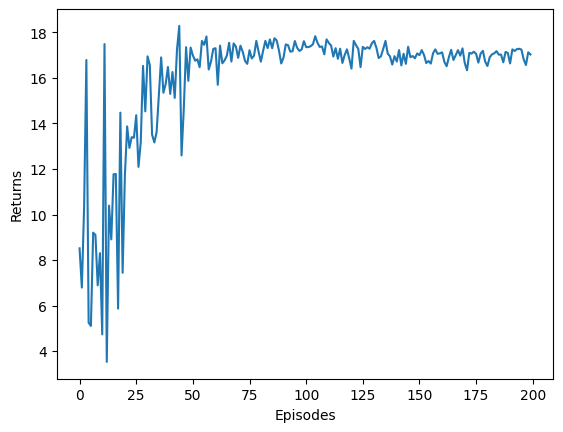

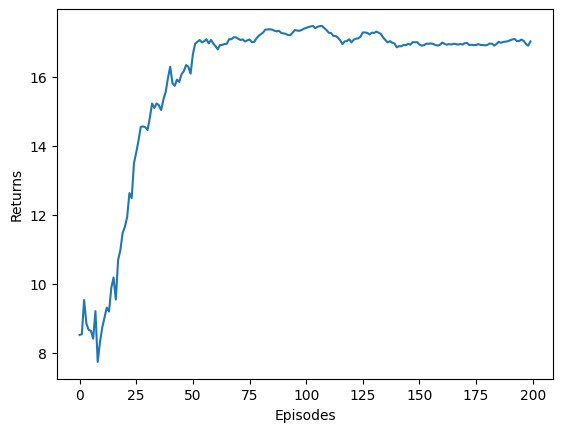

出界次数： 0


In [ ]:
# 游标训练环境
import random
import matplotlib
import matplotlib.pyplot as plt
import gym
from gym import spaces
from numpy.linalg import norm
from torch.distributions import Normal
import random
import numpy as np
from tqdm import tqdm
import collections
import torch
from torch import nn
import torch.nn.functional as F

# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.bounce_back = None
        self.min_pos = -10
        self.max_pos = 10
        self.position = None
        self.out_range = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        self.out_range = 0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.bounce_back = 0
        self.position += move # + np.random.normal()
        if self.position < self.min_pos or self.position > self.max_pos:
            self.bounce_back=1
        # self.position = np.clip(self.position, self.min_pos, self.max_pos) # 栏杆

        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
            self.out_range = 1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            reward1 = 1 - np.linalg.norm(self.position - (self.max_pos + self.min_pos) / 2) / 10
        else:
            reward1 = 0 # -3
        # if self.bounce_back:
        #     reward1-=2
        return reward1

# 改进算法

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()

        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(torch.nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_out = torch.nn.Linear(prev_size, 1)

    def forward(self, x):
        y = self.net(x)
        return self.fc_out(y)


class SquashedNormal:
    """带 tanh 压缩的高斯分布。

    采样：u ~ N(mu, std)（使用 rsample 支持 reparam），a = tanh(u)
    log_prob：基于 u 的 normal.log_prob(u) 并加上 tanh 的 Jacobian 修正项：-sum log(1 - tanh(u)^2)
    注意：外部需要把动作缩放到环境动作空间（仿射变换）。
    """

    def __init__(self, mu, std, eps=1e-6):
        self.mu = mu
        self.std = std
        self.normal = Normal(mu, std)
        self.eps = eps

    def sample(self):
        # rsample 以支持 reparameterization 重参数化采样, 结果是可导的
        u = self.normal.rsample()
        a = torch.tanh(u)
        return a, u

    def log_prob(self, a, u):
        # a: tanh(u)
        # log_prob(u) - sum log(1 - tanh(u)^2)
        # normal.log_prob 返回每个维度的 log_prob，需要 sum
        # 为数值稳定性添加小量
        log_prob_u = self.normal.log_prob(u)
        # jacobian term
        jacobian = torch.log(1 - a.pow(2) + self.eps) # fixme 应该+还是-？
        # sum over action dim, keep dims consistent: return (N, 1)
        # 取消提前求和 # return (log_prob_u - jacobian).sum(-1, keepdim=True)
        return log_prob_u - jacobian  # 返回形状为 (batch_size, action_dim)

    def entropy(self):
        # 近似：使用 base normal 的熵之和（不考虑 tanh 的修正）
        # 这在实践中通常足够，若需精确熵可用采样估计
        ent = self.normal.entropy().sum(-1)
        return ent


class PolicyNetContinuous(torch.nn.Module):
    """输出未压缩（pre-squash）的 mu 和 std。

    网络输出的 mu 是未经过 tanh 的原始均值，std 用 softplus 保证正值。
    不在网络内部做 action scaling，统一在采样/执行阶段处理。
    """

    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(nn.Linear(prev_size, layer_size))
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_mu = torch.nn.Linear(prev_size, action_dim)
        self.fc_std = torch.nn.Linear(prev_size, action_dim)

    def forward(self, x, min_std=1e-3):
        x = self.net(x)
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x))
        std = torch.clamp(std, min=min_std)
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法，支持时变动作区间（每步 amin/amax 不同）。

    设计说明（必须注意）：
    - 如果环境的动作约束随状态变化（amin/amax 为时变），则经验回放需保存当时的
      amin/amax（请把它放到 transition_dict['action_bounds']，形状为 (N, 2) 或每步的 (amin, amax)）。
    - 如果 action_bounds 在训练时始终恒定（标量或单个区间），也可以直接把 action_bound
      作为常数传入 update()。
    - 在本实现中，策略内部输出的是标准化前的 mu 和 std（即对 u 的分布参数）。
      对应的执行动作为：a = tanh(u)  -> normalized in (-1,1)
      最后缩放到真实区间： a_exec = amin + (a+1)/2 * (amax-amin)
    - update() 中会把存储的 a_exec "反归一化" 回 normalized a（[-1,1]），以便计算 log_prob。
    '''

    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def _scale_action_to_exec(self, a, action_bounds):
        """把 normalized action a (in [-1,1]) 缩放到环境区间。

        action_bounds 可以是：
        - 单个数值：action_bound，表示对称区间 [-action_bound, action_bound]
        - 长度为 2 的元组/列表 (amin, amax)
        - 每步的数组，形状 (N, 2)
        """
        if isinstance(action_bounds, (int, float)):
            # 对称区间
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a.dtype, device=a.device)
        amax = torch.as_tensor(amax, dtype=a.dtype, device=a.device)
        # a in (-1,1) -> scale to [amin, amax]
        return amin + (a + 1.0) * 0.5 * (amax - amin)

    def _unscale_exec_to_normalized(self, a_exec, action_bounds):
        """把执行动作 a_exec 反向归一化到 [-1,1]。

        如果 action_bounds 是标量，视作对称区间 [-b, b]。
        返回 normalized action (in (-1,1)).
        """
        if isinstance(action_bounds, (int, float)):
            amin = -float(action_bounds)
            amax = float(action_bounds)
        else:
            amin, amax = action_bounds
        amin = torch.as_tensor(amin, dtype=a_exec.dtype, device=a_exec.device)
        amax = torch.as_tensor(amax, dtype=a_exec.dtype, device=a_exec.device)
        # 防止除以零
        span = (amax - amin)
        span = torch.where(span == 0, torch.tensor(1e-6, device=span.device, dtype=span.dtype), span)
        a = 2.0 * (a_exec - amin) / span - 1.0
        # numerical stability
        return a.clamp(-0.999999, 0.999999)

    def take_action(self, state, action_bounds=1.0, explore=True):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        dist = SquashedNormal(mu, std)
        if explore:
            a_norm, u = dist.sample()
        else:
            # use mean action: tanh(mu)
            u = mu
            a_norm = torch.tanh(u)

        a_exec = self._scale_action_to_exec(a_norm, action_bounds)
        return a_exec[0].cpu().detach().numpy().flatten()
    

    def update(self, transition_dict, action_bounds=None):
        """更新函数兼容以下几种调用方式：
        - 如果 action_bounds 是 None：期望 transition_dict 中包含 'action_bounds'，其形状为 (N,2) 或每步 (amin,amax)
        - 如果 action_bounds 是标量/二元元组/数组：作为全局固定区间使用

        transition_dict 必须包含 keys: 'states','actions','rewards','next_states','dones'
        当动作区间随步变化时，必须包含 'action_bounds' 与之对应。
        存储的 'actions' 应当是环境执行动作 a_exec（未归一化）。
        """
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions_exec = torch.tensor(transition_dict['actions'], dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        if action_bounds is None:
            if 'action_bounds' in transition_dict:
                action_bounds = transition_dict['action_bounds']
            else:
                action_bounds = 1.0  # 默认值

        # 将 action_bounds 处理为每步的数组
        if isinstance(action_bounds, (int, float)):
            # 对称区间，扩展为每步相同的区间
            # action_bounds_arr = [action_bounds] * len(transition_dict['actions'])
            amin_list = [-float(action_bounds)] * len(transition_dict['actions'])
            amax_list = [float(action_bounds)] * len(transition_dict['actions'])
        elif isinstance(action_bounds, (tuple, list, np.ndarray)) and len(action_bounds) == 2:
            # 二元元组或列表，扩展为每步相同的 min 和 max
            amin_list = [float(action_bounds[0])] * len(transition_dict['actions'])
            amax_list = [float(action_bounds[1])] * len(transition_dict['actions'])
        else:
            # 每步不同的区间，直接解包
            amin_list = [float(ab[0]) if isinstance(ab, (tuple, list, np.ndarray)) else -float(ab) for ab in action_bounds]
            amax_list = [float(ab[1]) if isinstance(ab, (tuple, list, np.ndarray)) else float(ab) for ab in action_bounds]

        # 转换为张量
        amin_tensor = torch.tensor(amin_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)
        amax_tensor = torch.tensor(amax_list, dtype=actions_exec.dtype, device=self.device).unsqueeze(-1)

        # 计算 td_target, advantage
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # 策略输出（未压缩的 mu,std）
        mu, std = self.actor(states)
        # 构造 SquashedNormal 并计算 old_log_probs
        dist = SquashedNormal(mu.detach(), std.detach())

        # 将执行动作反向归一化到 [-1,1]，以便计算 log_prob
        actions_normalized = self._unscale_exec_to_normalized(actions_exec, (amin_tensor, amax_tensor))
        
        # 反算 u = atanh(a)
        u_old = torch.atanh(actions_normalized)
        old_log_probs = dist.log_prob(actions_normalized, u_old)

        if torch.isnan(old_log_probs).any():
            raise ValueError("old_log_probs 包含 NaN，检查 action_bounds 或 actions 的合法性")

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            if torch.isnan(mu).any() or torch.isnan(std).any():
                raise ValueError("NaN in Actor outputs in loop")
            critic_values = self.critic(states)
            if torch.isnan(critic_values).any():
                raise ValueError("NaN in Critic outputs in loop")

            dist = SquashedNormal(mu, std)
            # 计算当前策略对历史执行动作的 log_prob（使用同一个 u_old）
            log_probs = dist.log_prob(actions_normalized, u_old)

            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            # 取消提前求和 # actor_loss = -torch.min(surr1, surr2).mean() - 0.1 * dist.entropy().mean()
            actor_loss = -torch.min(surr1, surr2).sum(-1).mean() - 0.1 * dist.entropy().mean()
            # ↑如果求和之和还要保留原先的张量维度，用torch.sum(torch.min(surr1,surr2),dim=-1,keepdim=True)

            critic_loss = F.mse_loss(self.critic(states), td_target.detach())
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()

            # 梯度裁剪
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=2)
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=2)

            self.actor_optimizer.step()
            self.critic_optimizer.step()


# 注意：为了兼容原来的训练循环，请在构造 transition_dict 时保证：
# - 'actions' 存储的是环境实际执行的动作 a_exec（未归一化）
# - 如果动作区间随步变化，则 transition_dict['action_bounds'] 应为长度为步数的序列，
#   其中每个元素是 (amin, amax) 或 标量 b（表示对称区间 [-b,b]）。
# 示例：
# transition = {
#   'states': [...],
#   'actions': [...],  # 执行到环境的动作
#   'rewards': [...],
#   'next_states': [...],
#   'dones': [...],
#   'action_bounds': [(amin0,amax0), (amin1,amax1), ...]  # 可选
# }

# 以上实现把 action_bounds 纳入了 update 的计算链路，从而保证了 log_prob 的计算与当时执行动作的一致性，
# 避免了因动作裁剪/投影导致的策略-执行分布不匹配，从根本上缓解了你提到的 update 中梯度爆炸问题。


# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200 # fixme 如果不限制最小方差，500 的时候会梯度爆炸, 限制后1000 也会爆炸
hidden_dims = [128]  # 128 fixme 层数大时actor梯度也会爆炸
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1


agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

out_range_count = 0
return_list = []
clear_batch_flag=1
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        if clear_batch_flag:
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': [], 'action_bounds': []}
            clear_batch_flag=0
        state = env.reset()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈

            # print('state', state, flush=True)
            
            max_action_bound = 3

            # 栏杆

            max_action = min(10-state[0], max_action_bound)
            min_action = max(-10-state[0], -max_action_bound)

            action_bound= (min_action, max_action)

            action = agent.take_action(state, action_bounds=action_bound, explore=True)

            next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            transition_dict['action_bounds'].append(action_bound)
            state = next_state
            episode_return += reward
        
        if env.out_range==1:
            out_range_count+=1
        return_list.append(episode_return)
        if 1: # len(transition_dict['dones'])>20: # 逐batch更新
            agent.update(transition_dict)
            clear_batch_flag=1
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

# %matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))

plt.show()

print("出界次数：", out_range_count)